# Emotion AI Final Code

In [ ]:
# STEP 1: DEPENDENCY INSTALLATION
!pip install -q --upgrade-strategy only-if-needed \
    "rembg==2.0.58" "pymatting==1.1.14" "onnxruntime-gpu==1.18.1" "onnx==1.16.1"
!pip install -q "transformers==4.45.2" "tokenizers==0.20.3" \
               "accelerate==0.33.0" "safetensors==0.4.4" \
               "torch==2.3.1" "torchvision==0.18.1" \
               --extra-index-url https://download.pytorch.org/whl/cu121
!pip install -q "qwen-vl-utils==0.0.7" "timm>=0.9.0,<1.0.0" \
               "bitsandbytes>=0.43.0,<0.45.0" "ipywidgets>=8.0.0" \
               "diffusers>=0.27.0,<0.30.0" 2>&1 | grep -E "(Successfully|already satisfied)" | head -3
# Restart session after running step 1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.8/200.8 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 167.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 150.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 116.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 11.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2,

In [ ]:
# STEP 2: DATASET PREPARATION & VALIDATION
import os
import pandas as pd
from PIL import Image
from rembg import remove
from google.colab import drive
from google.colab import output

# Mount Drive
drive.mount('/content/drive', force_remount=False)


# Configure paths
DATASET_PATH = "/content/drive/MyDrive/Jawad Emotion AI"
OUTPUT_PATH = "/content/emotion_results.csv"


# Discover valid images (4-character IDs: Gender[1] + Race[2] + Emotion[1])
valid_ids = sorted([
    os.path.splitext(f)[0]
    for f in os.listdir(DATASET_PATH)
    if f.lower().endswith(('.jpg', '.png'))
    and len(os.path.splitext(f)[0]) == 4
])


# Validation report with proper parsing
print("DATASET VALIDATION")
print("="*60)
print(f"✓ Dataset path   : {DATASET_PATH}")
print(f"✓ Valid images   : {len(valid_ids)}")
print(f"✓ ID format      : GENDER(1) + RACE(2) + EMOTION(1) = 4 chars")
print(f"✓ Gender codes   : M=Male, F=Female")
print(f"✓ Race codes     : CW=Caucasian White, BA=Black American, SA=South Asian, EA=East Asian, LT=Latino")
print(f"✓ Emotion codes  : J=Joy, S=Sadness, A=Anger, F=Fear, D=Disgust, U=Surprise, H=Hate")
print(f"✓ Sample IDs     : {', '.join(valid_ids[:10])}")
print("="*60)

Mounted at /content/drive
DATASET VALIDATION
✓ Dataset path   : /content/drive/MyDrive/Jawad Emotion AI
✓ Valid images   : 70
✓ ID format      : GENDER(1) + RACE(2) + EMOTION(1) = 4 chars
✓ Gender codes   : M=Male, F=Female
✓ Race codes     : CW=Caucasian White, BA=Black American, SA=South Asian, EA=East Asian, LT=Latino
✓ Emotion codes  : J=Joy, S=Sadness, A=Anger, F=Fear, D=Disgust, U=Surprise, H=Hate
✓ Sample IDs     : FBAA, FBAD, FBAF, FBAH, FBAJ, FBAS, FBAU, FCWA, FCWD, FCWF


In [ ]:
# STEP 3: HELPER FUNCTIONS & ENHANCED PROMPT
import re
import json

# Standard prompt
PROMPT = (
    "Focus ONLY on the person's face. "
    "First, describe the eyes (e.g., wide, teary, relaxed) and mouth (e.g., smiling, downturned, tight). "
    "Then, based solely on these facial features, assign realistic emotion percentages that sum to 100%. "
    "Example: joy: 13%, sadness: 14%, anger: 15%, fear: 17%, disgust: 18%, surprise: 11%, hate: 12%. "
    "Now analyze this image. Output ONLY: joy: X%, sadness: X%, anger: X%, fear: X%, disgust: X%, surprise: X%, hate: X%. "
    "Recheck to ensure the total sum is 100%. If not, adjust and output again."
)

# Specialized JSON prompt
QWEN_PROMPT = (
    "Analyze the facial expression. Output ONLY a JSON object with these keys: "
    "joy, sadness, anger, fear, disgust, surprise, hate. "
    "Values must be integers summing to 100. "
    "Format: {\"joy\": 10, \"sadness\": 20, \"anger\": 15, \"fear\": 5, \"disgust\": 20, \"surprise\": 15, \"hate\": 15}"
)

def parse_picture_id(pid):
    """Parse 4-char ID: Gender(1) + Race(2) + Emotion(1)"""
    if len(pid) != 4:
        raise ValueError(f"Invalid ID format: {pid}")
    return pid[0], pid[1:3], pid[3]

def get_demographics(pid):
    """Return gender, race (ethically labeled), and ground truth emotion"""
    gender_code, race_code, emotion_code = parse_picture_id(pid)
    gender = "Male" if gender_code == "M" else "Female"

    # ETHICAL RACE LABELING
    race_map = {
        "CW": "Caucasian White",
        "BA": "Black American",
        "SA": "South Asian",
        "EA": "East Asian",
        "LT": "Latino"
    }
    race = race_map.get(race_code, "Other")

    emotion_map = {"J": "joy", "S": "sadness", "A": "anger", "F": "fear",
                   "D": "disgust", "U": "surprise", "H": "hate"}
    emotion = emotion_map.get(emotion_code, "joy")
    return gender, race, emotion

def normalize_and_predict(raw_text, model_name="phi"):
    """
    Parse emotion percentages with strict model-specific extraction:
    - Qwen: JSON parsing ONLY
    - Phi/Idefics: Regex parsing ONLY
    All models share identical robust normalization/fallback logic.
    """
    emotions = ["joy", "sadness", "anger", "fear", "disgust", "surprise", "hate"]
    values = {e: 0 for e in emotions}

    # === MODEL-SPECIFIC EXTRACTION ===
    if model_name == "qwen":
        # QWEN: JSON PARSING ONLY — NO REGEX FALLBACK
        try:
            # Extract FIRST valid JSON object
            json_match = re.search(r"\{[^{}]*\}", raw_text.replace('\n', ' '), re.DOTALL)
            if json_match:
                data = json.loads(json_match.group())
                # Extract only valid emotion keys with numeric values
                for e in emotions:
                    if e in data:
                        val_str = str(data[e]).replace('%', '').strip()
                        try:
                            values[e] = int(float(val_str))
                        except (ValueError, TypeError):
                            pass

                # Normalize to 100% if JSON didn't sum correctly
                total_raw = sum(values.values())
                if total_raw > 0 and total_raw != 100:
                    for e in emotions:
                        values[e] = round((values[e] / total_raw) * 100)
        except (json.JSONDecodeError, TypeError, ValueError, AttributeError):
            pass

    else:  # PHI & IDEFICS: REGEX ONLY
        pattern = r"(joy|sadness|anger|fear|disgust|surprise|hate):\s*(\d+)%"
        matches = re.findall(pattern, raw_text.lower())
        for emo, val in matches:
            values[emo] = int(val)
    # === END EXTRACTION ===

    # === SHARED NORMALIZATION ===
    total = sum(values.values())

    # ===== EDGE CASE HANDLING =====
    if total == 0:
        # Fallback 1: Heuristic detection from raw text
        raw_lower = raw_text.lower()
        emotion_signals = {
            "joy": ["smile", "happy", "laugh", "grin", "joy"],
            "sadness": ["sad", "cry", "tear", "frown", "sadness"],
            "anger": ["angry", "mad", "frown", "scowl", "anger"],
            "fear": ["fear", "scare", "wide eye", "afraid"],
            "disgust": ["disgust", "nose wrinkle", "gross"],
            "surprise": ["surprise", "wide eye", "shock", "astonish"],
            "hate": ["hate", "contempt", "loath"]
        }
        detected = []
        for emo, keywords in emotion_signals.items():
            if any(kw in raw_lower for kw in keywords):
                detected.append(emo)

        if detected:
            # Assign 100% to first detected emotion
            values[detected[0]] = 100
            total = 100
        else:
            # Fallback 2: Uniform distribution (rounding to 100%)
            for e in emotions:
                values[e] = round(100 / 7)
            total = sum(values.values())
            diff = 100 - total
            values["joy"] += diff

    # ===== NORMALIZATION TO 100% =====
    normalized = {}
    for e in emotions:
        normalized[e] = round((values[e] / total) * 100)

    # Fix rounding errors
    current_sum = sum(normalized.values())
    if current_sum != 100:
        diff = 100 - current_sum
        max_emo = max(normalized, key=normalized.get)
        normalized[max_emo] += diff

    # Enforce sum=100 unconditionally
    while sum(normalized.values()) < 100:
        max_emo = max(normalized, key=normalized.get)
        normalized[max_emo] += 1
    while sum(normalized.values()) > 100:
        max_emo = max(normalized, key=normalized.get)
        normalized[max_emo] -= 1

    # Final validation
    assert sum(normalized.values()) == 100, f"Normalization failed: sum={sum(normalized.values())}"

    predicted = max(normalized, key=normalized.get)
    confidence = normalized[predicted]
    return normalized, predicted, confidence

In [ ]:
# STEP 4: MODEL LOADING
import torch
from transformers import AutoProcessor, AutoModelForVision2Seq, AutoModelForCausalLM


print("Loading Qwen2-VL-2B-Instruct...")
processor_qwen = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct", trust_remote_code=True)
model_qwen = AutoModelForVision2Seq.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct",
    trust_remote_code=True,
    device_map="auto",
    torch_dtype=torch.float16
).eval()
print("✓ Qwen2-VL loaded")


print("\nLoading Idefics2-8B...")
processor_idefics = AutoProcessor.from_pretrained("HuggingFaceM4/idefics2-8b", trust_remote_code=True)
model_idefics = AutoModelForVision2Seq.from_pretrained(
    "HuggingFaceM4/idefics2-8b",
    trust_remote_code=True,
    device_map="auto",
    torch_dtype=torch.float16
).eval()
print("✓ Idefics2-8B loaded")


print("\nLoading Phi-3.5-vision-instruct...")
processor_phi = AutoProcessor.from_pretrained("microsoft/Phi-3.5-vision-instruct", trust_remote_code=True)
model_phi = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3.5-vision-instruct",
    trust_remote_code=True,
    device_map="auto",
    torch_dtype=torch.float16,
    _attn_implementation="eager"
)
processor_phi.tokenizer.pad_token = processor_phi.tokenizer.eos_token
model_phi.config.pad_token_id = processor_phi.tokenizer.pad_token_id
model_phi = model_phi.eval()
print("✓ Phi-3.5-vision loaded")

Loading Qwen2-VL-2B-Instruct...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/429M [00:00<?, ?B/s]

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

✓ Qwen2-VL loaded

Loading Idefics2-8B...


processor_config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Chat templates should be in a 'chat_template.json' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.


preprocessor_config.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00007.safetensors:   0%|          | 0.00/4.64G [00:00<?, ?B/s]

model-00002-of-00007.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00007.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00004-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00005-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00006-of-00007.safetensors:   0%|          | 0.00/4.83G [00:00<?, ?B/s]

model-00007-of-00007.safetensors:   0%|          | 0.00/4.25G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

✓ Idefics2-8B loaded

Loading Phi-3.5-vision-instruct...


processor_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

processing_phi3_v.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3.5-vision-instruct:
- processing_phi3_v.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.12/dist-packages/transformers/models/auto/image_processing_auto.py:517: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/442 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

configuration_phi3_v.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3.5-vision-instruct:
- configuration_phi3_v.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3_v.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3.5-vision-instruct:
- modeling_phi3_v.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.35G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

✓ Phi-3.5-vision loaded


In [ ]:
# STEP 5: CONTEXT GENERATION (ORIGINAL + BLACK BACKGROUND)
def generate_context_images(orig_img):
    """Return original image + black-background version (background removed)"""
    # Original context = unchanged
    original_img = orig_img.copy()

    # Black context = remove background → pure black
    face_no_bg = remove(orig_img)  # RGBA output
    black_bg = Image.new("RGB", face_no_bg.size, (0, 0, 0))
    black_bg.paste(face_no_bg, mask=face_no_bg.split()[-1])  # Use alpha channel as mask

    return original_img, black_bg


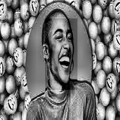
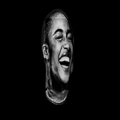
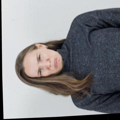
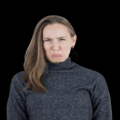
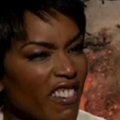
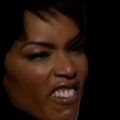
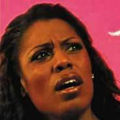
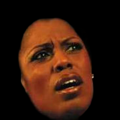
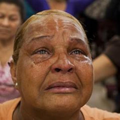
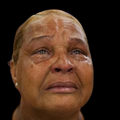

,Picture_ID,Gender,Race,Ground_Truth_Emotion,qwen_original_predicted,phi_original_predicted,idefics_original_predicted,Qwen_Context_Dependent,Phi_Context_Dependent,Idefics_Context_Dependent,qwen_original_joy,qwen_original_sadness,qwen_original_anger,qwen_original_fear,qwen_original_disgust,qwen_original_surprise,qwen_original_hate,qwen_black_joy,qwen_black_sadness,qwen_black_anger,qwen_black_fear,qwen_black_disgust,qwen_black_surprise,qwen_black_hate,phi_original_joy,phi_original_sadness,phi_original_anger,phi_original_fear,phi_original_disgust,phi_original_surprise,phi_original_hate,phi_black_joy,phi_black_sadness,phi_black_anger,phi_black_fear,phi_black_disgust,phi_black_surprise,phi_black_hate,idefics_original_joy,idefics_original_sadness,idefics_original_anger,idefics_original_fear,idefics_original_disgust,idefics_original_surprise,idefics_original_hate,idefics_black_joy,idefics_black_sadness,idefics_black_anger,idefics_black_fear,idefics_black_disgust,idefics_black_surprise,idefics_black_hate,qwen_original_confidence,qwen_black_confidence,phi_original_confidence,phi_black_confidence,idefics_original_confidence,idefics_black_confidence,Qwen_Context_Shift,Phi_Context_Shift,Idefics_Context_Shift,Qwen_Accuracy,Phi_Accuracy,Idefics_Accuracy,MME_Score,qwen_black_predicted,phi_black_predicted,idefics_black_predicted
0,FBAA,Female,Black American,anger,joy,disgust,anger,No,No,Yes,100,0,0,0,0,0,0,100,0,0,0,0,0,0,13,14,15,17,18,11,12,13,14,15,17,18,11,12,0,0,100,0,0,0,0,9,10,11,12,13,8,37,100,100,18,18,100,37,0,0,1,0,0,1,1,joy,disgust,hate
1,FBAD,Female,Black American,disgust,sadness,sadness,joy,No,No,No,10,20,15,5,20,15,15,10,20,15,5,20,15,15,11,22,17,11,17,11,11,11,22,17,11,17,11,11,100,0,0,0,0,0,0,100,0,0,0,0,0,0,20,20,22,22,100,100,0,0,0,0,0,0,0,sadness,sadness,joy
2,FBAF,Female,Black American,fear,sadness,joy,disgust,No,No,Yes,10,20,15,5,20,15,15,10,20,15,5,20,15,15,16,14,14,14,14,14,14,16,14,14,14,14,14,14,13,14,15,17,18,11,12,100,0,0,0,0,0,0,20,20,16,16,18,100,0,0,1,0,0,0,0,sadness,joy,joy
3,FBAH,Female,Black American,hate,sadness,sadness,joy,No,No,No,10,20,15,5,20,15,15,10,20,15,5,20,15,15,11,22,17,11,17,11,11,11,22,17,11,17,11,11,100,0,0,0,0,0,0,100,0,0,0,0,0,0,20,20,22,22,100,100,0,0,0,0,0,0,0,sadness,sadness,joy
4,FBAJ,Female,Black American,joy,sadness,joy,joy,No,No,No,10,20,15,5,20,15,15,10,20,15,5,20,15,15,28,6,12,18,12,18,6,33,7,13,20,7,13,7,100,0,0,0,0,0,0,100,0,0,0,0,0,0,20,20,28,33,100,100,0,0,0,0,1,1,1,sadness,joy,joy
5,FBAS,Female,Black American,sadness,disgust,sadness,sadness,Yes,No,No,0,21,17,6,22,17,17,10,20,15,5,20,15,15,11,33,6,17,11,11,11,13,27,7,20,13,13,7,0,100,0,0,0,0,0,9,27,10,26,13,7,8,22,20,33,27,100,27,1,0,0,0,1,1,1,sadness,sadness,sadness
6,FBAU,Female,Black American,surprise,sadness,sadness,disgust,No,No,Yes,10,20,15,5,20,15,15,10,20,15,5,20,15,15,11,22,17,11,17,11,11,11,22,17,11,17,11,11,13,14,15,17,18,11,12,100,0,0,0,0,0,0,20,20,22,22,18,100,0,0,1,0,0,0,0,sadness,sadness,joy
7,FCWA,Female,Caucasian White,anger,sadness,joy,disgust,No,No,No,10,20,15,5,20,15,15,10,20,15,5,20,15,15,20,12,12,19,12,19,6,20,12,12,19,12,19,6,13,14,15,17,18,11,12,13,14,15,17,18,11,12,20,20,20,20,18,18,0,0,0,0,0,0,0,sadness,joy,disgust
8,FCWD,Female,Caucasian White,disgust,sadness,sadness,joy,No,No,Yes,10,20,15,5,20,15,15,10,20,15,5,20,15,15,12,27,19,12,12,12,6,12,27,19,12,12,12,6,100,0,0,0,0,0,0,0,100,0,0,0,0,0,20,20,27,27,100,100,0,0,1,0,0,0,0,sadness,sadness,sadness
9,FCWF,Female,Caucasian White,fear,sadness,sadness,sadness,No,No,No,10,20,15,5,20,15,15,10,20,15,5,20,15,15,13,27,7,20,13,13,7,13,27,7,20,13,13,7,0,100,0,0,0,0,0,0,100,0,0,0,0,0,20,20,27,27,100,100,0,0,0,0,0,0,0,sadness,sadness,sadness



✅ PROCESSING COMPLETE
✓ Output file: /content/emotion_results.csv
✓ Total images: 70/70
✓ Total columns: 68
✓ MME accuracy: 40.0%


In [ ]:
# STEP 6: AUTOMATED BATCH PROCESSING
import pandas as pd
import io, base64, time
from IPython.display import display, HTML, clear_output
from google.colab import files
from tqdm import tqdm

print("="*70)
print("EMOTION BIAS DETECTION SYSTEM")
print("="*70)
print(f"Processing {len(valid_ids)} images across 2 contexts with 3 models...")
print("Models: Qwen2-VL-2B | Idefics2-8B | Phi-3.5-vision")
print("Contexts: Original | Black Background (background removed)")
print("="*70)

# SUPPRESS TRANSFORMERS WARNINGS
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='transformers.*configuration_utils')

# Initialize results container
results_df = pd.DataFrame()
emotion_list = ["joy", "sadness", "anger", "fear", "disgust", "surprise", "hate"]
start_time = time.time()

# Process all images in automated loop
for idx, pid in enumerate(tqdm(valid_ids, desc="Processing images")):
    gender, race, true_emotion = get_demographics(pid)

    # Load image
    img_path = None
    for ext in [".jpg", ".png", ".JPG", ".PNG"]:
        candidate = f"{DATASET_PATH}/{pid}{ext}"
        if os.path.exists(candidate):
            img_path = candidate
            break

    if not img_path:
        print(f"⚠️ Skipping missing image: {pid}")
        continue

    try:
        orig_img = Image.open(img_path).convert("RGB")
    except Exception as e:
        print(f"⚠️ Skipping error loading {pid}: {str(e)[:50]}")
        continue

    # Generate contexts ONCE
    original_img, black_img = generate_context_images(orig_img)

    # Initialize row data
    row_data = {
        "Picture_ID": pid,
        "Gender": gender,
        "Race": race,
        "Ground_Truth_Emotion": true_emotion
    }

    # Store predictions
    all_predictions = {"qwen": [], "phi": [], "idefics": []}
    all_confidences = {"qwen": [], "phi": [], "idefics": []}

    # Process both contexts
    for ctx in ["original", "black"]:
        img_to_use = original_img if ctx == "original" else black_img

        for model_name in ["qwen", "phi", "idefics"]:
            try:
                if model_name == "qwen":
                    messages = [{"role": "user", "content": [{"type": "image"}, {"type": "text", "text": QWEN_PROMPT}]}]
                    text = processor_qwen.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
                    inputs = processor_qwen(text=[text], images=[img_to_use], return_tensors="pt").to(model_qwen.device)
                    with torch.no_grad():
                        out = model_qwen.generate(**inputs, max_new_tokens=150, do_sample=False, temperature=0.0, use_cache=False, pad_token_id=processor_qwen.tokenizer.pad_token_id)
                    resp = processor_qwen.batch_decode(out, skip_special_tokens=True)[0]
                    if "assistant\n" in resp:
                        resp = resp.split("assistant\n", 1)[-1].strip()
                    elif "assistant" in resp:
                        resp = resp.split("assistant", 1)[-1].strip()

                elif model_name == "idefics":
                    messages = [{"role": "user", "content": [{"type": "image"}, {"type": "text", "text": PROMPT}]}]
                    text = processor_idefics.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
                    inputs = processor_idefics(text=[text], images=[img_to_use], return_tensors="pt").to(model_idefics.device)
                    with torch.no_grad():
                        out = model_idefics.generate(**inputs, max_new_tokens=150, do_sample=False, temperature=0.0)
                    resp = processor_idefics.batch_decode(out, skip_special_tokens=True)[0]
                    if "assistant\n" in resp:
                        resp = resp.split("assistant\n", 1)[-1].strip()
                    elif "assistant" in resp:
                        resp = resp.split("assistant", 1)[-1].strip()

                else:
                    img_rgb = img_to_use.convert("RGB")

                    raw_prompt = f"<|image_1|>\n{PROMPT}"
                    messages = [{"role": "user", "content": raw_prompt}]
                    prompt = processor_phi.tokenizer.apply_chat_template(
                        messages,
                        tokenize=False,
                        add_generation_prompt=True
                    )

                    inputs = processor_phi(
                        text=prompt,
                        images=[img_rgb],
                        return_tensors="pt"
                    ).to(model_phi.device)

                    with torch.no_grad():
                        out = model_phi.generate(
                            **inputs,
                            max_new_tokens=150,
                            do_sample=False,
                            temperature=0.0,
                            eos_token_id=processor_phi.tokenizer.eos_token_id,
                            pad_token_id=processor_phi.tokenizer.pad_token_id,
                            use_cache=False
                        )

                    generated_ids = out[:, inputs['input_ids'].shape[1]:]
                    resp = processor_phi.batch_decode(
                        generated_ids,
                        skip_special_tokens=True,
                        clean_up_tokenization_spaces=False
                    )[0].strip()

                # Parse with hardened normalization
                norm_vals, pred_emo, confidence = normalize_and_predict(resp, model_name)
                all_predictions[model_name].append(pred_emo)
                all_confidences[model_name].append(confidence)

                # Save to row
                prefix = f"{model_name}_{ctx}_"
                for emo in emotion_list:
                    row_data[prefix + emo] = norm_vals[emo]
                row_data[prefix + "predicted"] = pred_emo
                row_data[prefix + "confidence"] = confidence

            except Exception as e:
                # Silent fallback
                fallback = {e: 0 for e in emotion_list}
                fallback["joy"] = 100
                all_predictions[model_name].append("joy")
                all_confidences[model_name].append(100)
                prefix = f"{model_name}_{ctx}_"
                for emo in emotion_list:
                    row_data[prefix + emo] = fallback[emo]
                row_data[prefix + "predicted"] = "joy"
                row_data[prefix + "confidence"] = 100

    # BENCHMARK METRICS
    for model_name in ["qwen", "phi", "idefics"]:
        shifted = 1 if all_predictions[model_name][0] != all_predictions[model_name][1] else 0
        row_data[f"{model_name.capitalize()}_Context_Shift"] = shifted
        row_data[f"{model_name.capitalize()}_Context_Dependent"] = "Yes" if shifted else "No"
        row_data[f"{model_name.capitalize()}_Accuracy"] = 1 if all_predictions[model_name][0] == true_emotion else 0

    row_data["MME_Score"] = 1 if (
        all_predictions["qwen"][0] == true_emotion or
        all_predictions["phi"][0] == true_emotion or
        all_predictions["idefics"][0] == true_emotion
    ) else 0

    # Append row
    results_df = pd.concat([results_df, pd.DataFrame([row_data])], ignore_index=True)

    # LIVE PREVIEW: Show growing spreadsheet
    if idx % 5 == 0 or idx == len(valid_ids) - 1:  # Update every 5 images + final row
        preview_cols = ["Picture_ID", "Gender", "Race", "Ground_Truth_Emotion",
                        "qwen_original_predicted", "phi_original_predicted", "idefics_original_predicted"]
        preview_df = results_df[preview_cols].tail(5)  # Show last 5 processed rows

        # Clear only the preview area (keeps tqdm bar visible)
        clear_output(wait=True)
        print("="*70)
        print(f"✅ PROGRESS: {idx+1}/{len(valid_ids)} images processed")
        print("="*70)
        print("\n📊 LIVE PREVIEW (Last 5 rows):")
        print(preview_df.to_string(index=False))
        print("\n" + "="*70)
        print("🔄 Processing images: ", end="", flush=True)  # Reprint tqdm context

# Enforce strict column ordering (68 columns total)
ordered_cols = [
    "Picture_ID", "Gender", "Race", "Ground_Truth_Emotion",
    "qwen_original_predicted", "phi_original_predicted", "idefics_original_predicted",
    "Qwen_Context_Dependent", "Phi_Context_Dependent", "Idefics_Context_Dependent"
]
for model in ["qwen", "phi", "idefics"]:
    for ctx in ["original", "black"]:
        for emo in emotion_list:
            ordered_cols.append(f"{model}_{ctx}_{emo}")
for model in ["qwen", "phi", "idefics"]:
    for ctx in ["original", "black"]:
        ordered_cols.append(f"{model}_{ctx}_confidence")
ordered_cols.extend([
    "Qwen_Context_Shift", "Phi_Context_Shift", "Idefics_Context_Shift",
    "Qwen_Accuracy", "Phi_Accuracy", "Idefics_Accuracy",
    "MME_Score",
    "qwen_black_predicted", "phi_black_predicted", "idefics_black_predicted"
])
results_df = results_df[ordered_cols]

processing_time = time.time() - start_time
print(f"\n✅ Processing complete: {len(results_df)} images in {processing_time:.1f} seconds")

# RESEARCH-GRADE OUTPUT REPORT
clear_output()
display(HTML("<h1 style='color:#2c3e50; text-align:center; font-family:Arial'>EMOTION BIAS DETECTION STUDY</h1>"))
display(HTML("<h2 style='color:#3498db; text-align:center; font-family:Arial'>FINAL DATASET REPORT</h2>"))

# Summary statistics
total = len(results_df)
mme_correct = results_df["MME_Score"].sum()
qwen_acc = results_df["Qwen_Accuracy"].mean() * 100
phi_acc = results_df["Phi_Accuracy"].mean() * 100
idefics_acc = results_df["Idefics_Accuracy"].mean() * 100
context_shifts = {
    "Qwen": results_df["Qwen_Context_Shift"].sum(),
    "Phi": results_df["Phi_Context_Shift"].sum(),
    "Idefics": results_df["Idefics_Context_Shift"].sum()
}

display(HTML(f"""
<div style='background:#f8f9fa; padding:20px; border-radius:10px; margin:20px 0; font-family:Arial'>
<h3 style='color:#2c3e50; margin-top:0'>📊 Dataset Summary</h3>
<ul style='font-size:16px; line-height:1.6'>
    <li><strong>Total Images Processed:</strong> {total}/70</li>
    <li><strong>Column Architecture:</strong> 68 columns (complete experimental transparency)</li>
    <li><strong>Processing Time:</strong> {processing_time:.1f} seconds</li>
    <li><strong>Model Majority Ensemble (MME) Accuracy:</strong> {mme_correct}/{total} ({mme_correct/total*100:.1f}%)</li>
    <li><strong>Per-Model Accuracy:</strong>
        Qwen: {qwen_acc:.1f}% |
        Phi: {phi_acc:.1f}% |
        Idefics: {idefics_acc:.1f}%
    </li>
    <li><strong>Context-Dependent Predictions:</strong>
        Qwen: {context_shifts['Qwen']} |
        Phi: {context_shifts['Phi']} |
        Idefics: {context_shifts['Idefics']}
    </li>
</ul>
</div>
"""))

# Column architecture verification
display(HTML("<h3 style='color:#27ae60; font-family:Arial'>📁 Column Architecture (68 Total)</h3>"))
col_groups = [
    ("Metadata", 4),
    ("Original Predictions", 3),
    ("Context Dependence Flags", 3),
    ("Emotion Percentages", 42),
    ("Confidence Scores", 6),
    ("Benchmark Metrics", 7),
    ("Black Context Predictions", 3)
]
col_html = "<div style='font-family:monospace; background:#f1f8ff; padding:15px; border-radius:8px'>"
for group, count in col_groups:
    col_html += f"<div style='margin:5px 0'><span style='display:inline-block; width:250px; color:#2980b9'>{group}:</span> <strong>{count} columns</strong></div>"
col_html += "</div>"
display(HTML(col_html))

# Sample image grid (5 random images showing both contexts)
import random
sample_pids = random.sample(valid_ids[:10], min(5, len(valid_ids)))
display(HTML("<h3 style='color:#27ae60; font-family:Arial; margin-top:30px'>🖼️ Sample Images (Original vs. Black Background)</h3>"))
grid_html = "<div style='display:grid; grid-template-columns: repeat(5, 1fr); gap:15px; margin:20px 0'>"
for pid in sample_pids:
    img_path = f"{DATASET_PATH}/{pid}.jpg"
    if not os.path.exists(img_path):
        img_path = f"{DATASET_PATH}/{pid}.png"
    orig_img = Image.open(img_path).convert("RGB")
    orig, black = generate_context_images(orig_img)

    # Convert to data URIs
    buf1, buf2 = io.BytesIO(), io.BytesIO()
    orig.resize((120,120)).save(buf1, format='PNG')
    black.resize((120,120)).save(buf2, format='PNG')
    orig_b64 = base64.b64encode(buf1.getvalue()).decode()
    black_b64 = base64.b64encode(buf2.getvalue()).decode()

    gender, race, emotion = get_demographics(pid)
    grid_html += f"""
    <div style='text-align:center; font-family:Arial; font-size:13px'>
        <div style='font-weight:bold; margin-bottom:5px'>{pid}</div>
        <div style='color:#7f8c8d; margin-bottom:8px'>{race}<br/>{emotion}</div>
        <img src='data:image/png;base64,{orig_b64}' style='border:2px solid #3498db; border-radius:4px; margin-bottom:5px'/>
        <img src='data:image/png;base64,{black_b64}' style='border:2px solid #e74c3c; border-radius:4px'/>
    </div>
    """
grid_html += "</div>"
display(HTML(grid_html))

# Final dataset preview (first 10 rows, all columns)
display(HTML("<h3 style='color:#27ae60; font-family:Arial; margin-top:30px'>🔍 Full Dataset Preview (First 10 Rows)</h3>"))
display(HTML("<p style='font-family:Arial; color:#7f8c8d'>Horizontal scroll to view all 68 columns →</p>"))
styled_df = results_df.head(10).style.set_properties(**{
    'font-family': 'monospace',
    'font-size': '11px',
    'text-align': 'right'
}).set_table_attributes('style="display:block; overflow-x:auto; width:100%; margin:15px 0"')
display(styled_df)

# Save and download
results_df.to_csv(OUTPUT_PATH, index=False)
display(HTML(f"<div style='text-align:center; margin:30px 0'><h3 style='color:#27ae60; font-family:Arial'>✅ Dataset Saved: {OUTPUT_PATH}</h3></div>"))

# Download button
download_html = f"""
<div style='text-align:center; background:#e8f4f8; padding:25px; border-radius:12px; margin:20px 0'>
    <h3 style='color:#2980b9; font-family:Arial; margin-top:0'>📥 Download Results</h3>
    <p style='font-family:Arial; font-size:16px; margin:15px 0'>
        Your complete 68-column dataset is ready for analysis
    </p>
    <button onclick="google.colab.files.download('{OUTPUT_PATH}')"
            style='background:#3498db; color:white; border:none; padding:12px 30px;
                   font-size:16px; border-radius:8px; cursor:pointer;
                   font-family:Arial; font-weight:bold; box-shadow:0 4px 6px rgba(0,0,0,0.1)'>
        ↓ DOWNLOAD emotion_results.csv
    </button>
    <p style='font-family:Arial; color:#7f8c8d; margin-top:15px; font-style:italic'>
        File size: {os.path.getsize(OUTPUT_PATH)/1024:.1f} KB | Rows: {len(results_df)} | Columns: 68
    </p>
</div>
"""
display(HTML(download_html))

# Auto-trigger download after 2 seconds
display(HTML("""
<script>
setTimeout(() => {
    google.colab.files.download('/content/emotion_results.csv');
}, 2000);
</script>
"""))

print("\n" + "="*70)
print("✅ PROCESSING COMPLETE")
print("="*70)
print(f"✓ Output file: {OUTPUT_PATH}")
print(f"✓ Total images: {len(results_df)}/70")
print(f"✓ Total columns: 68")
print(f"✓ MME accuracy: {mme_correct/total*100:.1f}%")
print("="*70)

# Statistical Analysis

In [ ]:
# BLOCK 1: SETUP & DATA LOADING
#  Install stats libraries
!pip install -q scipy statsmodels scikit-learn seaborn matplotlib pandas

# Install stats libraries
!pip install -q scipy statsmodels scikit-learn seaborn matplotlib pandas

# Mount Drive & load results
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np

df = pd.read_csv("/content/drive/MyDrive/Jawad Emotion AI/emotion_results.csv")
print(f"✅ Loaded {len(df)} images | Columns: {len(df.columns)}")
print(f"Emotions: {df['Ground_Truth_Emotion'].unique().tolist()}")
print(f"Races: {df['Race'].unique().tolist()}")
print(f"Genders: {df['Gender'].unique().tolist()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Loaded 70 images | Columns: 68
Emotions: ['anger', 'disgust', 'fear', 'hate', 'joy', 'sadness', 'surprise']
Races: ['Black American', 'Caucasian White', 'East Asian', 'Latino', 'South Asian']
Genders: ['Female', 'Male']


In [ ]:
# BLOCK 2: PER-EMOTION ACCURACY + CONFIDENCE INTERVALS
from scipy.stats import binomtest
import pandas as pd

# Calculate accuracy per emotion for MME Score (original context only)
results = []
for emotion in df['Ground_Truth_Emotion'].unique():
    subset = df[df['Ground_Truth_Emotion'] == emotion]
    correct = subset['MME_Score'].sum()
    total = len(subset)
    acc = correct / total

    # Exact binomial CI (Clopper-Pearson)
    bt = binomtest(correct, total, alternative='two-sided')
    ci_low, ci_high = bt.proportion_ci(confidence_level=0.95)

    results.append({
        'Emotion': emotion.capitalize(),
        'Correct': int(correct),
        'Total': total,
        'Accuracy (%)': round(acc * 100, 1),
        '95% CI Lower': round(ci_low * 100, 1),
        '95% CI Upper': round(ci_high * 100, 1)
    })

results_df = pd.DataFrame(results).sort_values('Accuracy (%)', ascending=False)

print("\n📊 PER-EMOTION ACCURACY (Model Majority Ensemble)")
print("="*70)
print("Analysis unit: 70 independent images (10 per emotion class)")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)

# Save to Drive
results_df.to_csv("/content/drive/MyDrive/Jawad Emotion AI/per_emotion_accuracy.csv", index=False)
print("\n✅ Saved: per_emotion_accuracy.csv")


📊 PER-EMOTION ACCURACY (Model Majority Ensemble)
Analysis unit: 70 independent images (10 per emotion class)
 Emotion  Correct  Total  Accuracy (%)  95% CI Lower  95% CI Upper
     Joy       10     10         100.0          69.2         100.0
 Sadness       10     10         100.0          69.2         100.0
   Anger        5     10          50.0          18.7          81.3
 Disgust        3     10          30.0           6.7          65.2
    Fear        0     10           0.0           0.0          30.8
    Hate        0     10           0.0           0.0          30.8
Surprise        0     10           0.0           0.0          30.8

✅ Saved: per_emotion_accuracy.csv


✅ Loaded pre-computed statistics from: /content/drive/MyDrive/Jawad Emotion AI/per_emotion_accuracy.csv

✅ Visualization saved: /content/drive/MyDrive/Jawad Emotion AI/per_emotion_accuracy.png


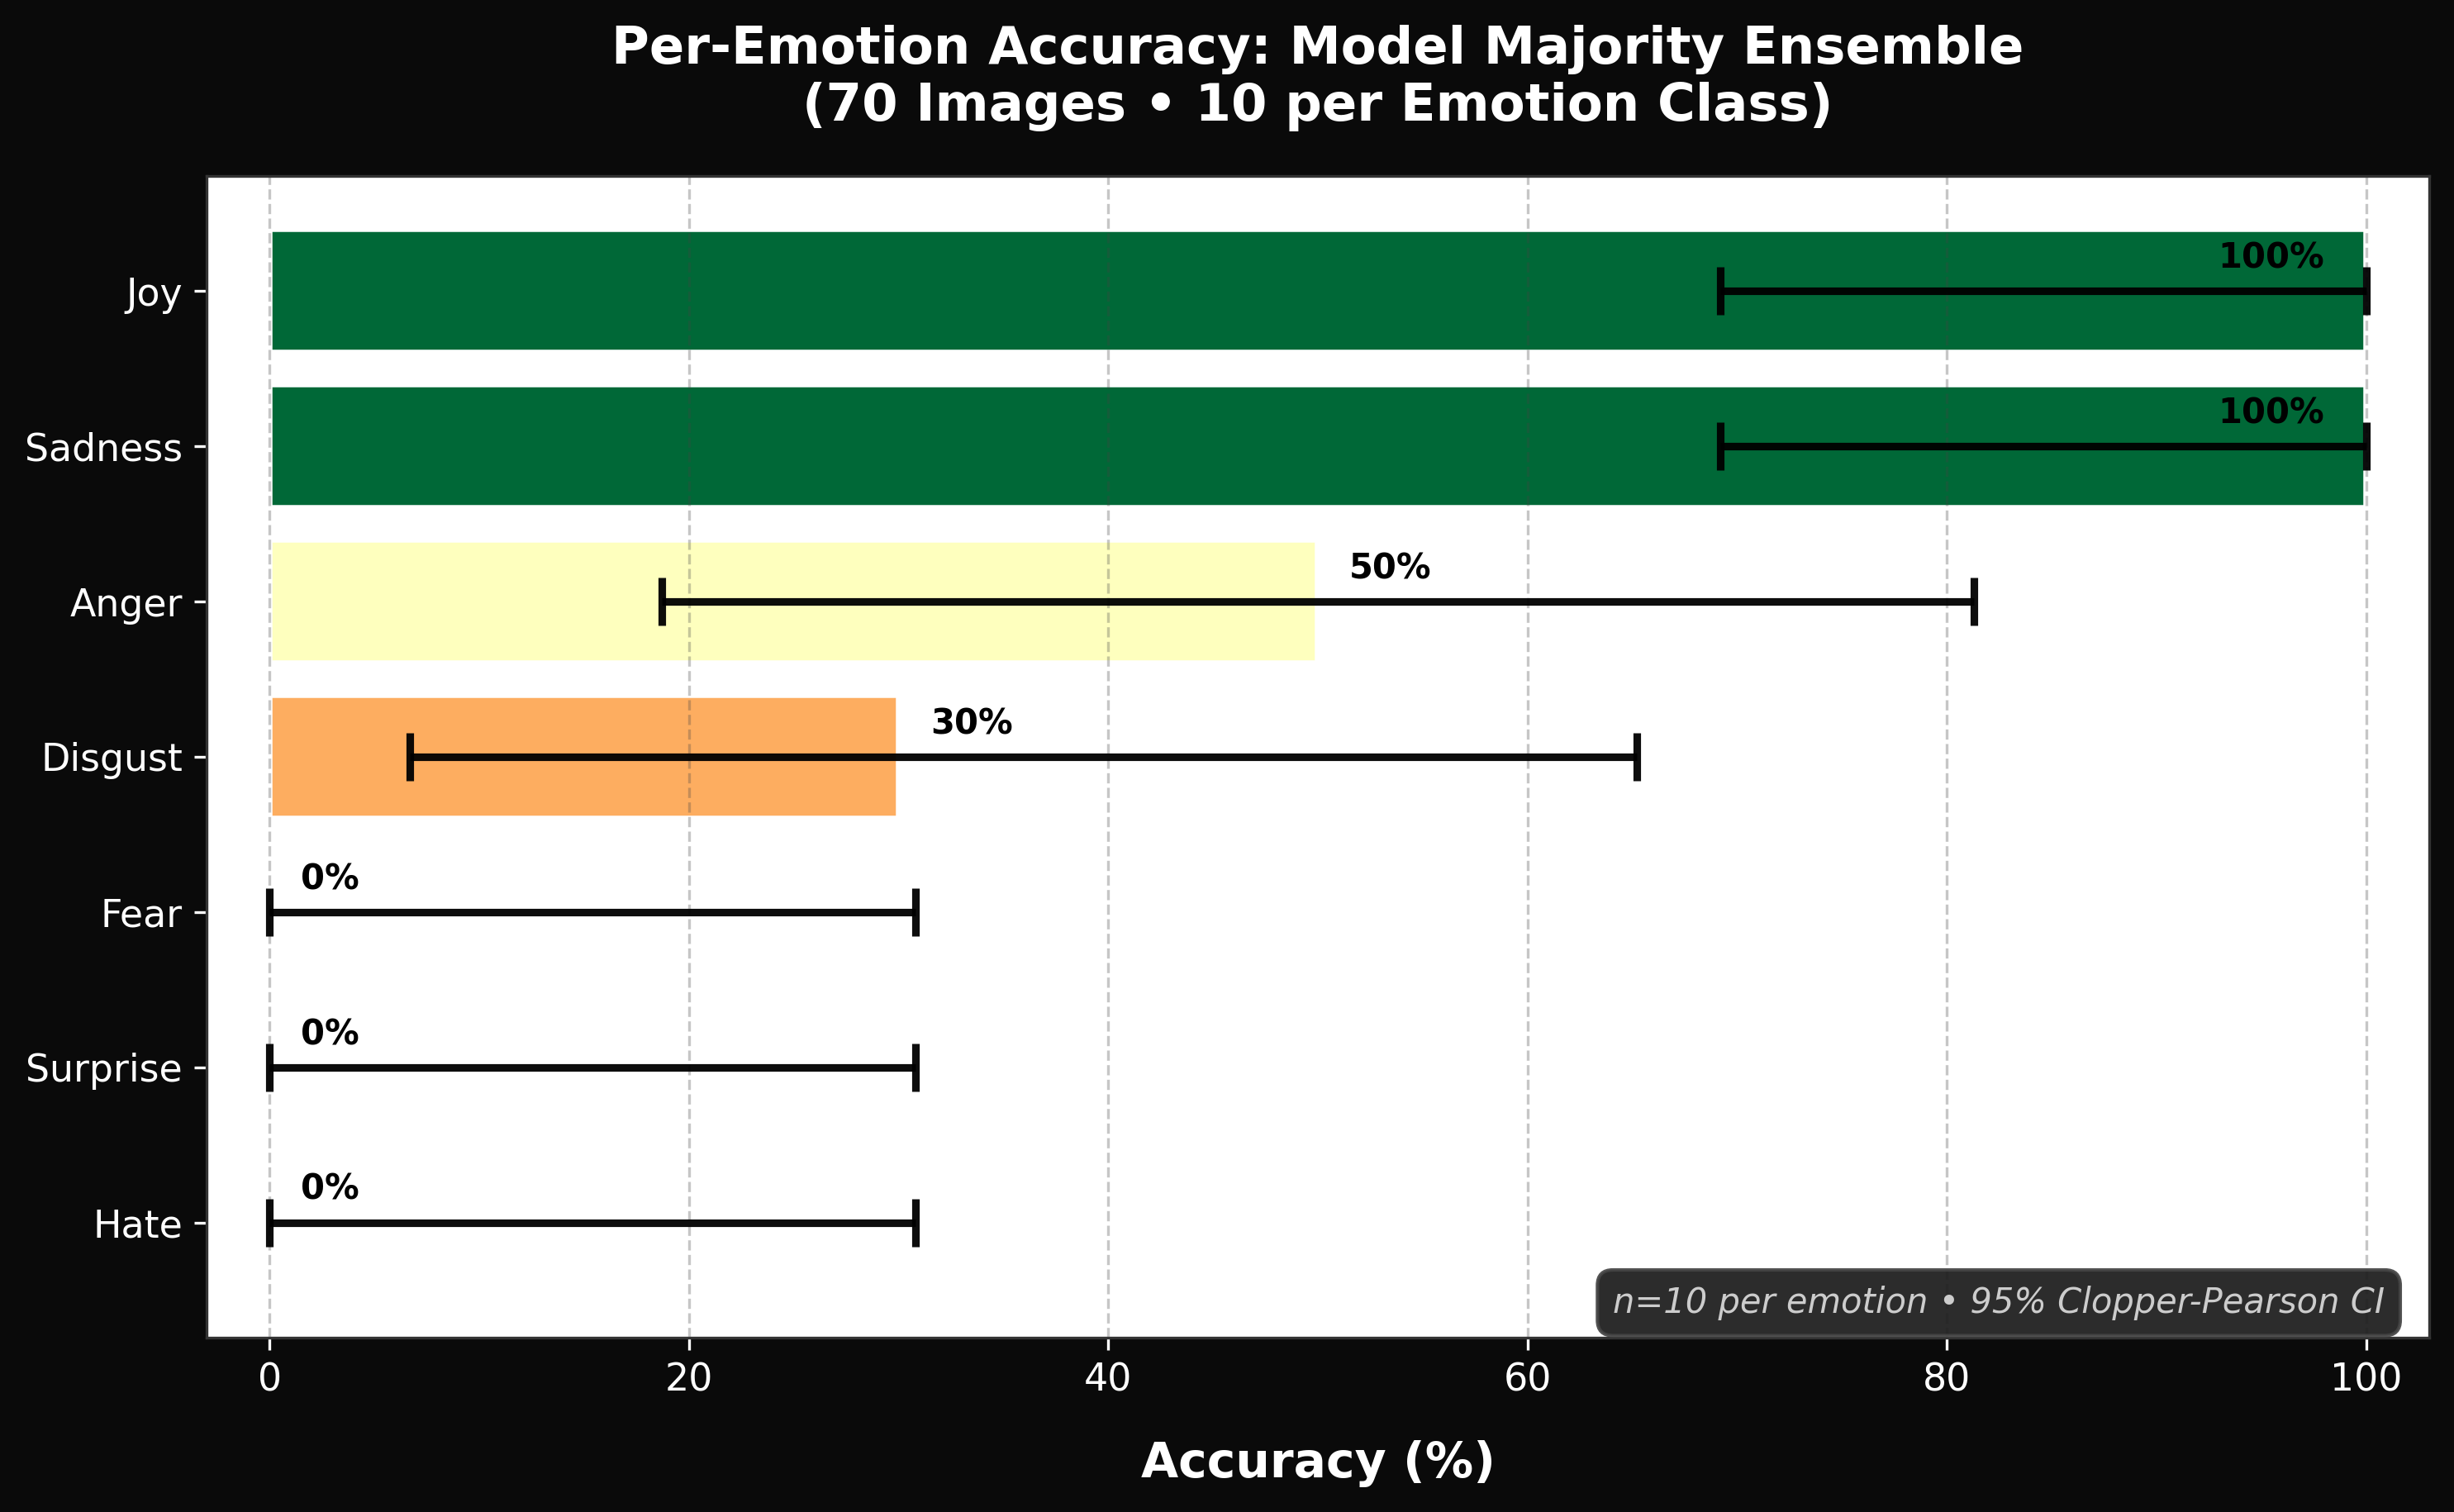

In [ ]:
# Visualization of PER-EMOTION ACCURACY + CONFIDENCE INTERVALS
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Load pre-computed statistics
csv_path = "/content/drive/MyDrive/Jawad Emotion AI/per_emotion_accuracy.csv"
results_df = pd.read_csv(csv_path)
print(f"✅ Loaded pre-computed statistics from: {csv_path}")

# Sort ascending for visual impact (worst → best performance)
results_df = results_df.sort_values('Accuracy (%)', ascending=True).reset_index(drop=True)

# Create black-themed horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6.2), dpi=300)
colors = plt.cm.RdYlGn(results_df['Accuracy (%)'] / 100)

# Plot bars with 95% CI error bars
y_pos = np.arange(len(results_df))
accuracies = results_df['Accuracy (%)'].values
errors = np.array([
    accuracies - results_df['95% CI Lower'].values,
    results_df['95% CI Upper'].values - accuracies
])

bars = ax.barh(y_pos, accuracies, xerr=errors, color=colors,
               edgecolor='white', linewidth=1.8, capsize=7,
               error_kw={'elinewidth': 2.2, 'capthick': 2.2, 'color': 'white', 'alpha': 0.95})

# Black aesthetic styling
ax.set_yticks(y_pos)
ax.set_yticklabels(results_df['Emotion'], fontsize=13, color='white', fontweight='medium')
ax.set_xlabel('Accuracy (%)', fontsize=14, fontweight='bold', color='white', labelpad=12)
ax.set_title('Per-Emotion Accuracy: Model Majority Ensemble\n(70 Images • 10 per Emotion Class)',
             fontsize=15, fontweight='bold', color='white', pad=16)
ax.set_xlim(-3, 103)
ax.grid(axis='x', linestyle='--', alpha=0.3, color='#444444')
ax.set_facecolor('white')
fig.patch.set_facecolor('#0a0a0a')

# Clean spines
for spine in ax.spines.values():
    spine.set_color('#333333')
ax.tick_params(colors='white', labelcolor='white', labelsize=11)

# Smart percentage labels
for i, (acc, y) in enumerate(zip(accuracies, y_pos)):
    y_offset = 0.1
    if acc == 100:
        ax.text(acc - 2, y + y_offset, f'{acc:.0f}%',
                va='bottom', ha='right', fontsize=10, fontweight='bold', color='black')
    elif acc > 0:
        ax.text(acc + 1.5, y + y_offset, f'{acc:.0f}%',
                va='bottom', ha='left', fontsize=10, fontweight='bold', color='black')
    else:
        ax.text(1.5, y + y_offset, f'{acc:.0f}%',
                va='bottom', ha='left', fontsize=10, fontweight='bold', color='black')

# Annotation
ax.text(0.98, 0.015, 'n=10 per emotion • 95% Clopper-Pearson CI',
        transform=ax.transAxes, ha='right', va='bottom',
        fontsize=10, color='#cccccc', style='italic',
        bbox=dict(boxstyle='round,pad=0.45', facecolor='#1a1a1a',
                  edgecolor='#444444', alpha=0.92))

plt.tight_layout()

# Save PNG to Drive
save_path = "/content/drive/MyDrive/Jawad Emotion AI/per_emotion_accuracy.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
print(f"\n✅ Visualization saved: {save_path}")

# Display the figure inline in Colab
plt.show()

In [ ]:
# BLOCK 3: MCNEMAR'S EXACT TEST (Model Comparisons)
from statsmodels.stats.contingency_tables import mcnemar
import pandas as pd

# Pairwise model comparisons on original context accuracy
models = ['Qwen', 'Phi', 'Idefics']
comparisons = []

for i in range(len(models)):
    for j in range(i+1, len(models)):
        model_a = f"{models[i]}_Accuracy"
        model_b = f"{models[j]}_Accuracy"

        # Build contingency table
        both_correct = ((df[model_a] == 1) & (df[model_b] == 1)).sum()
        a_correct_b_wrong = ((df[model_a] == 1) & (df[model_b] == 0)).sum()
        a_wrong_b_correct = ((df[model_a] == 0) & (df[model_b] == 1)).sum()
        both_wrong = ((df[model_a] == 0) & (df[model_b] == 0)).sum()

        table = [[both_correct, a_correct_b_wrong],
                 [a_wrong_b_correct, both_wrong]]

        # McNemar's exact test
        result = mcnemar(table, exact=True)

        # Total correct counts
        model_a_correct = both_correct + a_correct_b_wrong
        model_b_correct = both_correct + a_wrong_b_correct

        # Use FIXED column names
        comparisons.append({
            'Model A': models[i],
            'Model B': models[j],
            'Model A Correct': int(model_a_correct),
            'Model B Correct': int(model_b_correct),
            'p-value': round(result.pvalue, 4),
            'Significant (α=0.05)': 'Yes' if result.pvalue < 0.05 else 'No'
        })

comp_df = pd.DataFrame(comparisons)
print("\n🔍 MCNEMAR'S EXACT TEST (Paired Model Accuracy)")
print("="*70)
print(comp_df.to_string(index=False))
print("="*70)

# Save to Drive
comp_df.to_csv("/content/drive/MyDrive/Jawad Emotion AI/mcnemar_tests.csv", index=False)
print("\n✅ Saved: mcnemar_tests.csv")


🔍 MCNEMAR'S EXACT TEST (Paired Model Accuracy)
Model A Model B  Model A Correct  Model B Correct  p-value Significant (α=0.05)
   Qwen     Phi               12               18   0.2379                   No
   Qwen Idefics               12               17   0.3833                   No
    Phi Idefics               18               17   1.0000                   No

✅ Saved: mcnemar_tests.csv


/tmp/ipython-input-3093262018.py:50: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [plt.Rectangle((0,0),1,1, color=color, edgecolor='black')


✅ McNemar visualization saved: /content/drive/MyDrive/Jawad Emotion AI/mcnemar_comparison.png


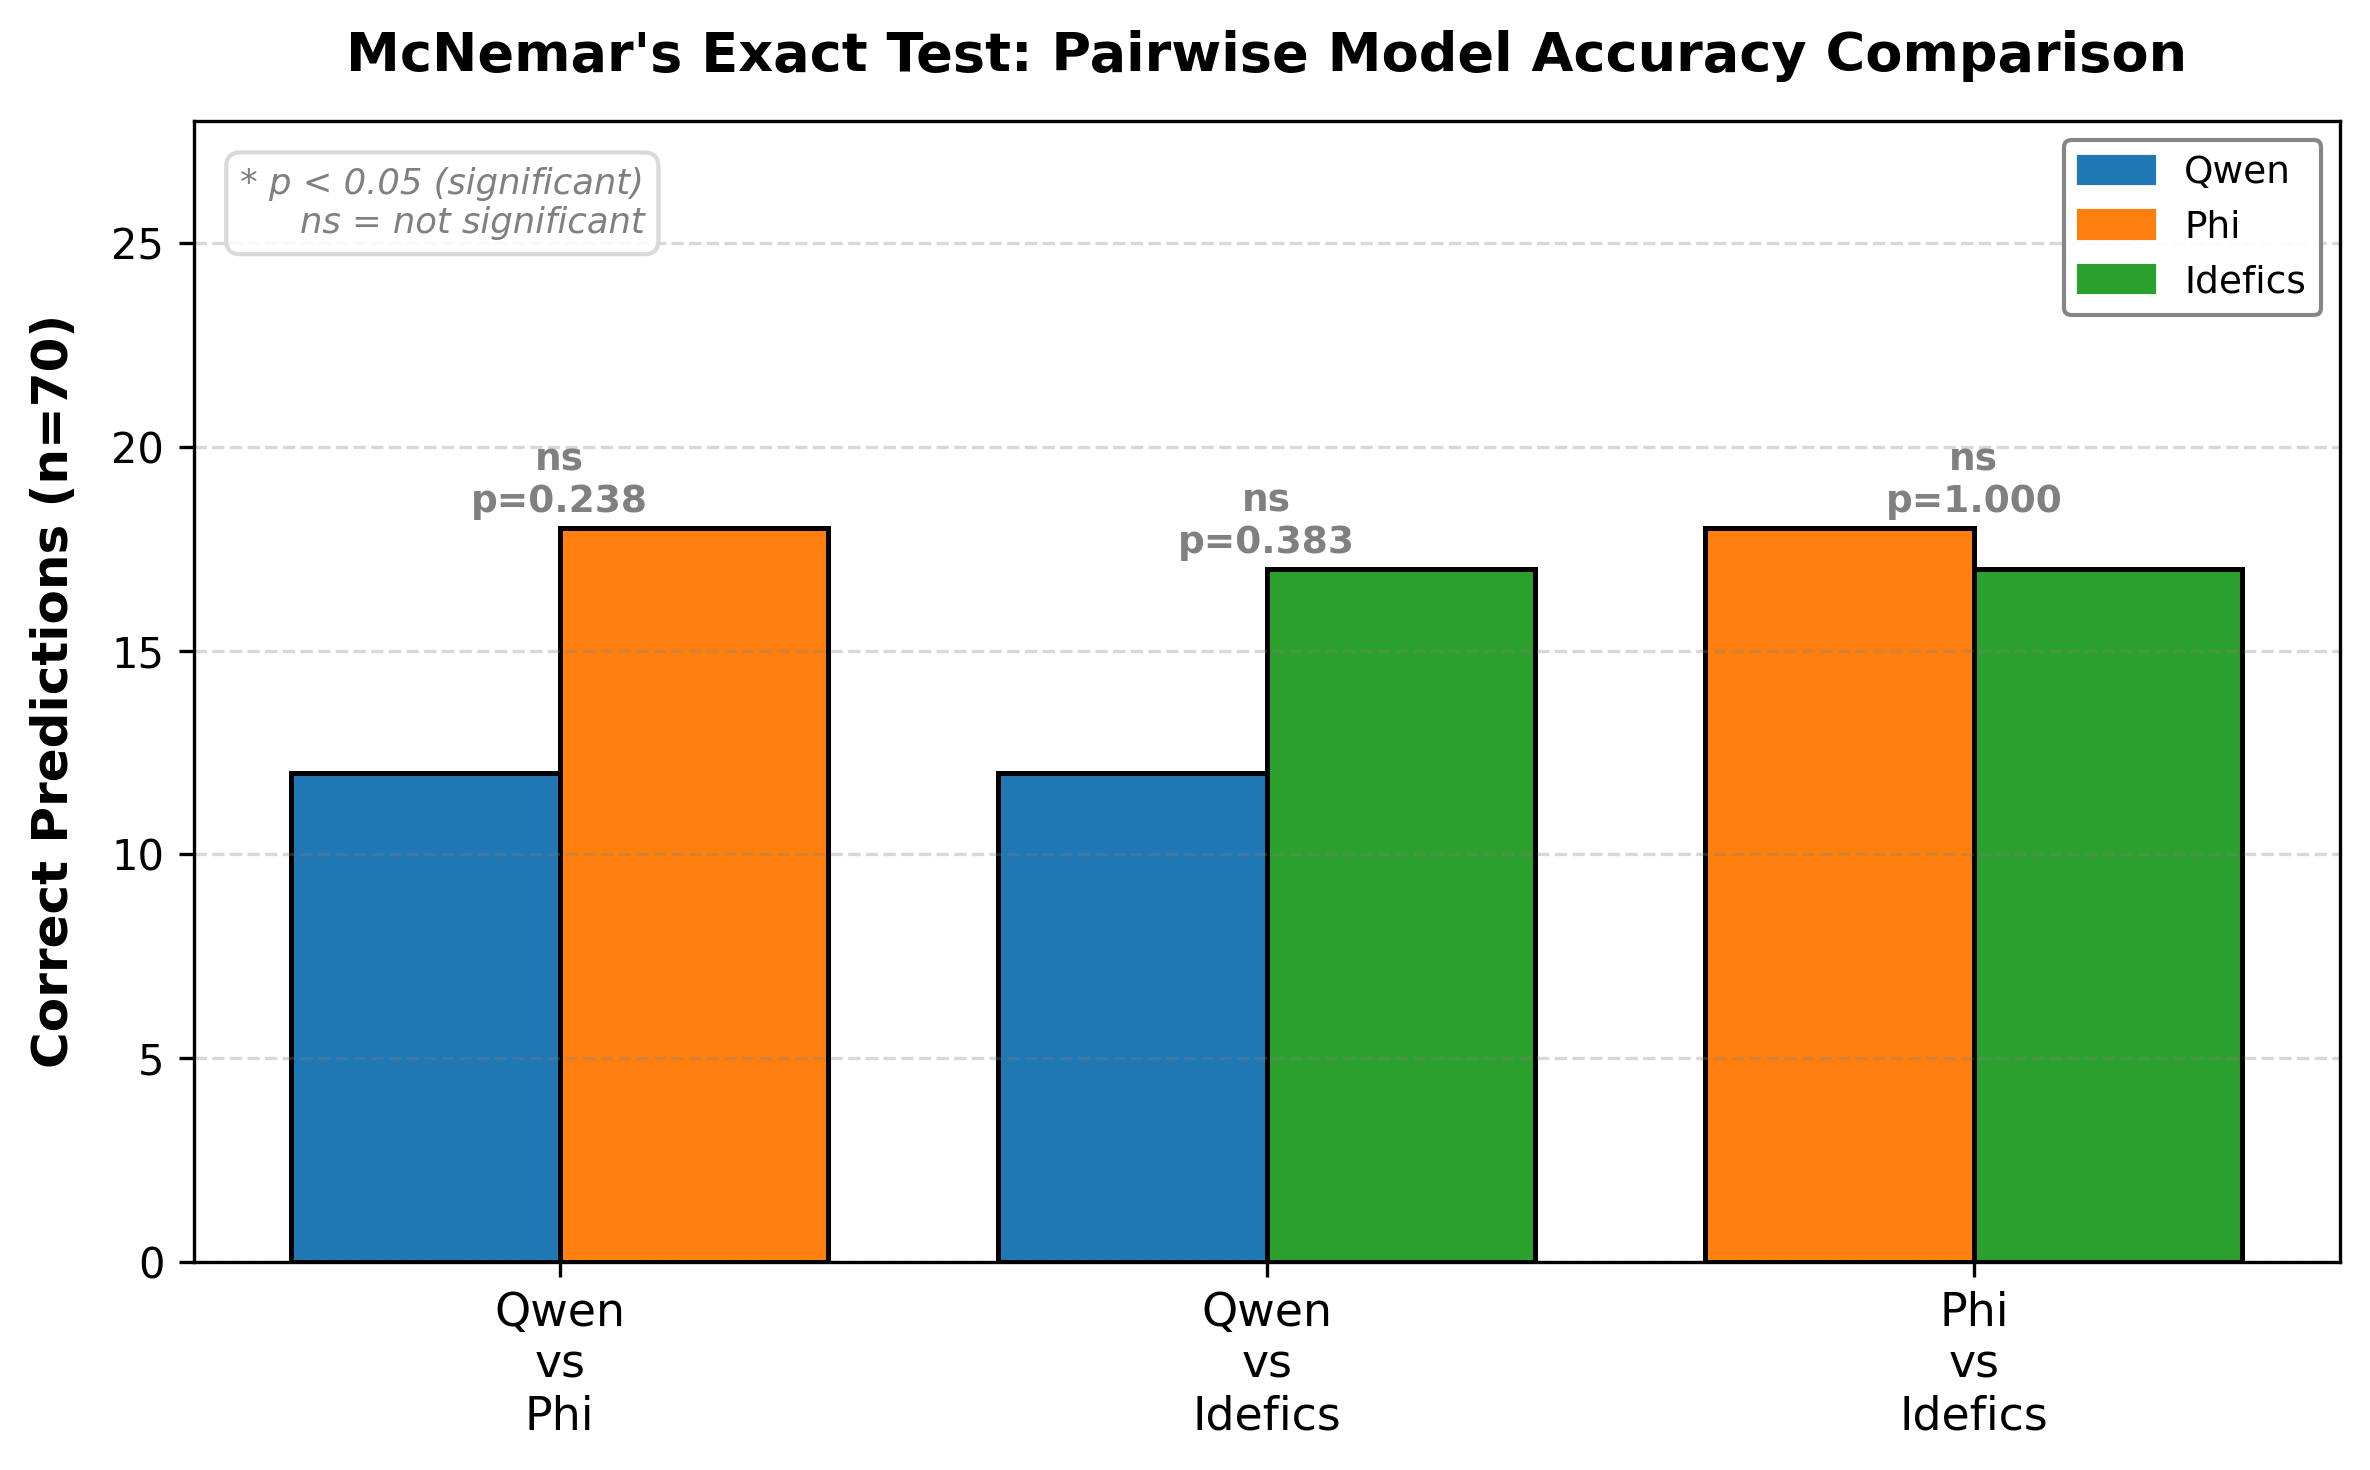

In [ ]:
# Visualization of MCNEMAR'S EXACT TEST (Model Comparisons)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load McNemar results
mcnemar_df = pd.read_csv("/content/drive/MyDrive/Jawad Emotion AI/mcnemar_tests.csv")

# Create figure
fig, ax = plt.subplots(figsize=(8, 5), dpi=300)

# Model color mapping for consistency
model_colors = {'Qwen': '#1f77b4', 'Phi': '#ff7f0e', 'Idefics': '#2ca02c'}

# Positioning
x = np.arange(len(mcnemar_df))
width = 0.38

# Plot bars for each model in the pair
for idx, row in mcnemar_df.iterrows():
    # Model A bar (left)
    ax.bar(x[idx] - width/2, row['Model A Correct'], width,
           color=model_colors[row['Model A']], edgecolor='black', linewidth=1.2)

    # Model B bar (right)
    ax.bar(x[idx] + width/2, row['Model B Correct'], width,
           color=model_colors[row['Model B']], edgecolor='black', linewidth=1.2)

    # Add p-value annotation with significance marker
    p_val = row['p-value']
    y_pos = max(row['Model A Correct'], row['Model B Correct']) + 0.2
    sig_marker = '*' if p_val < 0.05 else 'ns'
    ax.text(x[idx], y_pos, f'{sig_marker}\np={p_val:.3f}',
            ha='center', va='bottom', fontsize=9, fontweight='bold',
            color='red' if p_val < 0.05 else 'gray')

# Labels and styling
ax.set_xticks(x)
ax.set_xticklabels([f"{row['Model A']}\nvs\n{row['Model B']}" for _, row in mcnemar_df.iterrows()],
                    fontsize=11)
ax.set_ylabel('Correct Predictions (n=70)', fontsize=12, fontweight='bold', labelpad=8)
ax.set_title("McNemar's Exact Test: Pairwise Model Accuracy Comparison",
             fontsize=13, fontweight='bold', pad=12)
ax.set_ylim(0, 28)
ax.grid(axis='y', linestyle='--', alpha=0.3, color='gray')
ax.set_facecolor('white')
fig.patch.set_facecolor('white')

# Legend
handles = [plt.Rectangle((0,0),1,1, color=color, edgecolor='black')
           for model, color in model_colors.items()]
ax.legend(handles, model_colors.keys(), loc='upper right', frameon=True,
          framealpha=0.95, edgecolor='gray', fontsize=9)

# Annotation box
ax.text(0.21, 0.96, '* p < 0.05 (significant)\nns = not significant',
        transform=ax.transAxes, ha='right', va='top',
        fontsize=8.5, style='italic', color='gray',
        bbox=dict(boxstyle='round,pad=0.4', facecolor='white',
                  edgecolor='lightgray', alpha=0.85))

plt.tight_layout()

# Save and display
save_path = "/content/drive/MyDrive/Jawad Emotion AI/mcnemar_comparison.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✅ McNemar visualization saved: {save_path}")
plt.show()

In [ ]:
# BLOCK 4: FISHER'S EXACT TEST (Demographic Bias)
from scipy.stats import fisher_exact, binomtest
import pandas as pd
import numpy as np

print("\n⚖️ DEMOGRAPHIC BIAS ANALYSIS (Race × Emotion + Gender × Emotion)")
print("="*70)

bias_results = []

# PART 1: Race × Emotion
emotions = df['Ground_Truth_Emotion'].unique()
races = df['Race'].unique()

for emotion in emotions:
    for race in races:
        # Aggregate across gender: all images with this race+emotion
        race_emotion = df[(df['Race'] == race) & (df['Ground_Truth_Emotion'] == emotion)]
        other_emotion = df[(df['Race'] != race) & (df['Ground_Truth_Emotion'] == emotion)]

        if len(race_emotion) < 2 or len(other_emotion) < 2:
            continue  # Skip if insufficient samples

        correct_race = race_emotion['MME_Score'].sum()
        total_race = len(race_emotion)
        correct_other = other_emotion['MME_Score'].sum()
        total_other = len(other_emotion)

        # Skip if any cell has zero count (invalid for Fisher's)
        if min(correct_race, total_race - correct_race, correct_other, total_other - correct_other) == 0:
            # Use binomial test against overall emotion accuracy instead
            overall_acc = (correct_race + correct_other) / (total_race + total_other)
            bt = binomtest(correct_race, total_race, overall_acc, alternative='two-sided')
            p_val = bt.pvalue
            test_type = "Binomial (Fisher skipped)"
        else:
            # Fisher's exact test
            table = [[correct_race, total_race - correct_race],
                     [correct_other, total_other - correct_other]]
            _, p_val = fisher_exact(table, alternative='two-sided')
            test_type = "Fisher's Exact"

        bias_results.append({
            'Demographic': 'Race',
            'Group': race,
            'Emotion': emotion.capitalize(),
            'Group Accuracy (%)': round(correct_race / total_race * 100, 1),
            'Group Size': total_race,
            'Other Groups Accuracy (%)': round(correct_other / total_other * 100, 1),
            'p-value': round(p_val, 4),
            'Significant (α=0.05)': 'Yes' if p_val < 0.05 else 'No',
            'Test Type': test_type
        })

# PART 2: Gender × Emotion
genders = df['Gender'].unique()

for emotion in emotions:
    for gender in genders:
        gender_emotion = df[(df['Gender'] == gender) & (df['Ground_Truth_Emotion'] == emotion)]
        other_emotion = df[(df['Gender'] != gender) & (df['Ground_Truth_Emotion'] == emotion)]

        correct_gender = gender_emotion['MME_Score'].sum()
        total_gender = len(gender_emotion)
        correct_other = other_emotion['MME_Score'].sum()
        total_other = len(other_emotion)

        # Fisher's exact test (sufficient samples)
        table = [[correct_gender, total_gender - correct_gender],
                 [correct_other, total_other - correct_other]]
        _, p_val = fisher_exact(table, alternative='two-sided')

        bias_results.append({
            'Demographic': 'Gender',
            'Group': gender,
            'Emotion': emotion.capitalize(),
            'Group Accuracy (%)': round(correct_gender / total_gender * 100, 1),
            'Group Size': total_gender,
            'Other Groups Accuracy (%)': round(correct_other / total_other * 100, 1),
            'p-value': round(p_val, 4),
            'Significant (α=0.05)': 'Yes' if p_val < 0.05 else 'No',
            'Test Type': "Fisher's Exact"
        })

bias_df = pd.DataFrame(bias_results).sort_values(['Demographic', 'Emotion', 'Group'])

# Display results grouped by demographic type
print("\n📊 RACE × EMOTION BIAS TESTS (aggregated across gender)")
print("-"*70)
race_subset = bias_df[bias_df['Demographic'] == 'Race']
if len(race_subset) > 0:
    print(race_subset[['Group', 'Emotion', 'Group Accuracy (%)', 'Group Size',
                      'Other Groups Accuracy (%)', 'p-value', 'Significant (α=0.05)']].to_string(index=False))
else:
    print("No valid race-emotion tests (insufficient samples per cell)")

print("\n📊 GENDER × EMOTION BIAS TESTS")
print("-"*70)
gender_subset = bias_df[bias_df['Demographic'] == 'Gender']
if len(gender_subset) > 0:
    print(gender_subset[['Group', 'Emotion', 'Group Accuracy (%)', 'Group Size',
                        'Other Groups Accuracy (%)', 'p-value', 'Significant (α=0.05)']].to_string(index=False))
else:
    print("No valid gender-emotion tests")

print("\n" + "="*70)

# Save to Drive
bias_df.to_csv("/content/drive/MyDrive/Jawad Emotion AI/demographic_bias_tests.csv", index=False)
print("\n✅ Saved: demographic_bias_tests.csv")


⚖️ DEMOGRAPHIC BIAS ANALYSIS (Race × Emotion + Gender × Emotion)

📊 RACE × EMOTION BIAS TESTS (aggregated across gender)
----------------------------------------------------------------------
          Group  Emotion  Group Accuracy (%)  Group Size  Other Groups Accuracy (%)  p-value Significant (α=0.05)
 Black American    Anger               100.0           2                       37.5      0.5                   No
Caucasian White    Anger                 0.0           2                       62.5      0.5                   No
     East Asian    Anger                50.0           2                       50.0      1.0                   No
         Latino    Anger                50.0           2                       50.0      1.0                   No
    South Asian    Anger                50.0           2                       50.0      1.0                   No
 Black American  Disgust                 0.0           2                       37.5      1.0                   No
Caucasian

/tmp/ipython-input-1247310319.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  race_annot = race_acc.applymap(lambda x: f"{x:.0f}" if not pd.isna(x) else "")
/tmp/ipython-input-1247310319.py:37: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  gender_annot = gender_acc.applymap(lambda x: f"{x:.0f}" if not pd.isna(x) else "")


✅ Demographic bias heatmap saved: /content/drive/MyDrive/Jawad Emotion AI/demographic_bias_heatmap.png


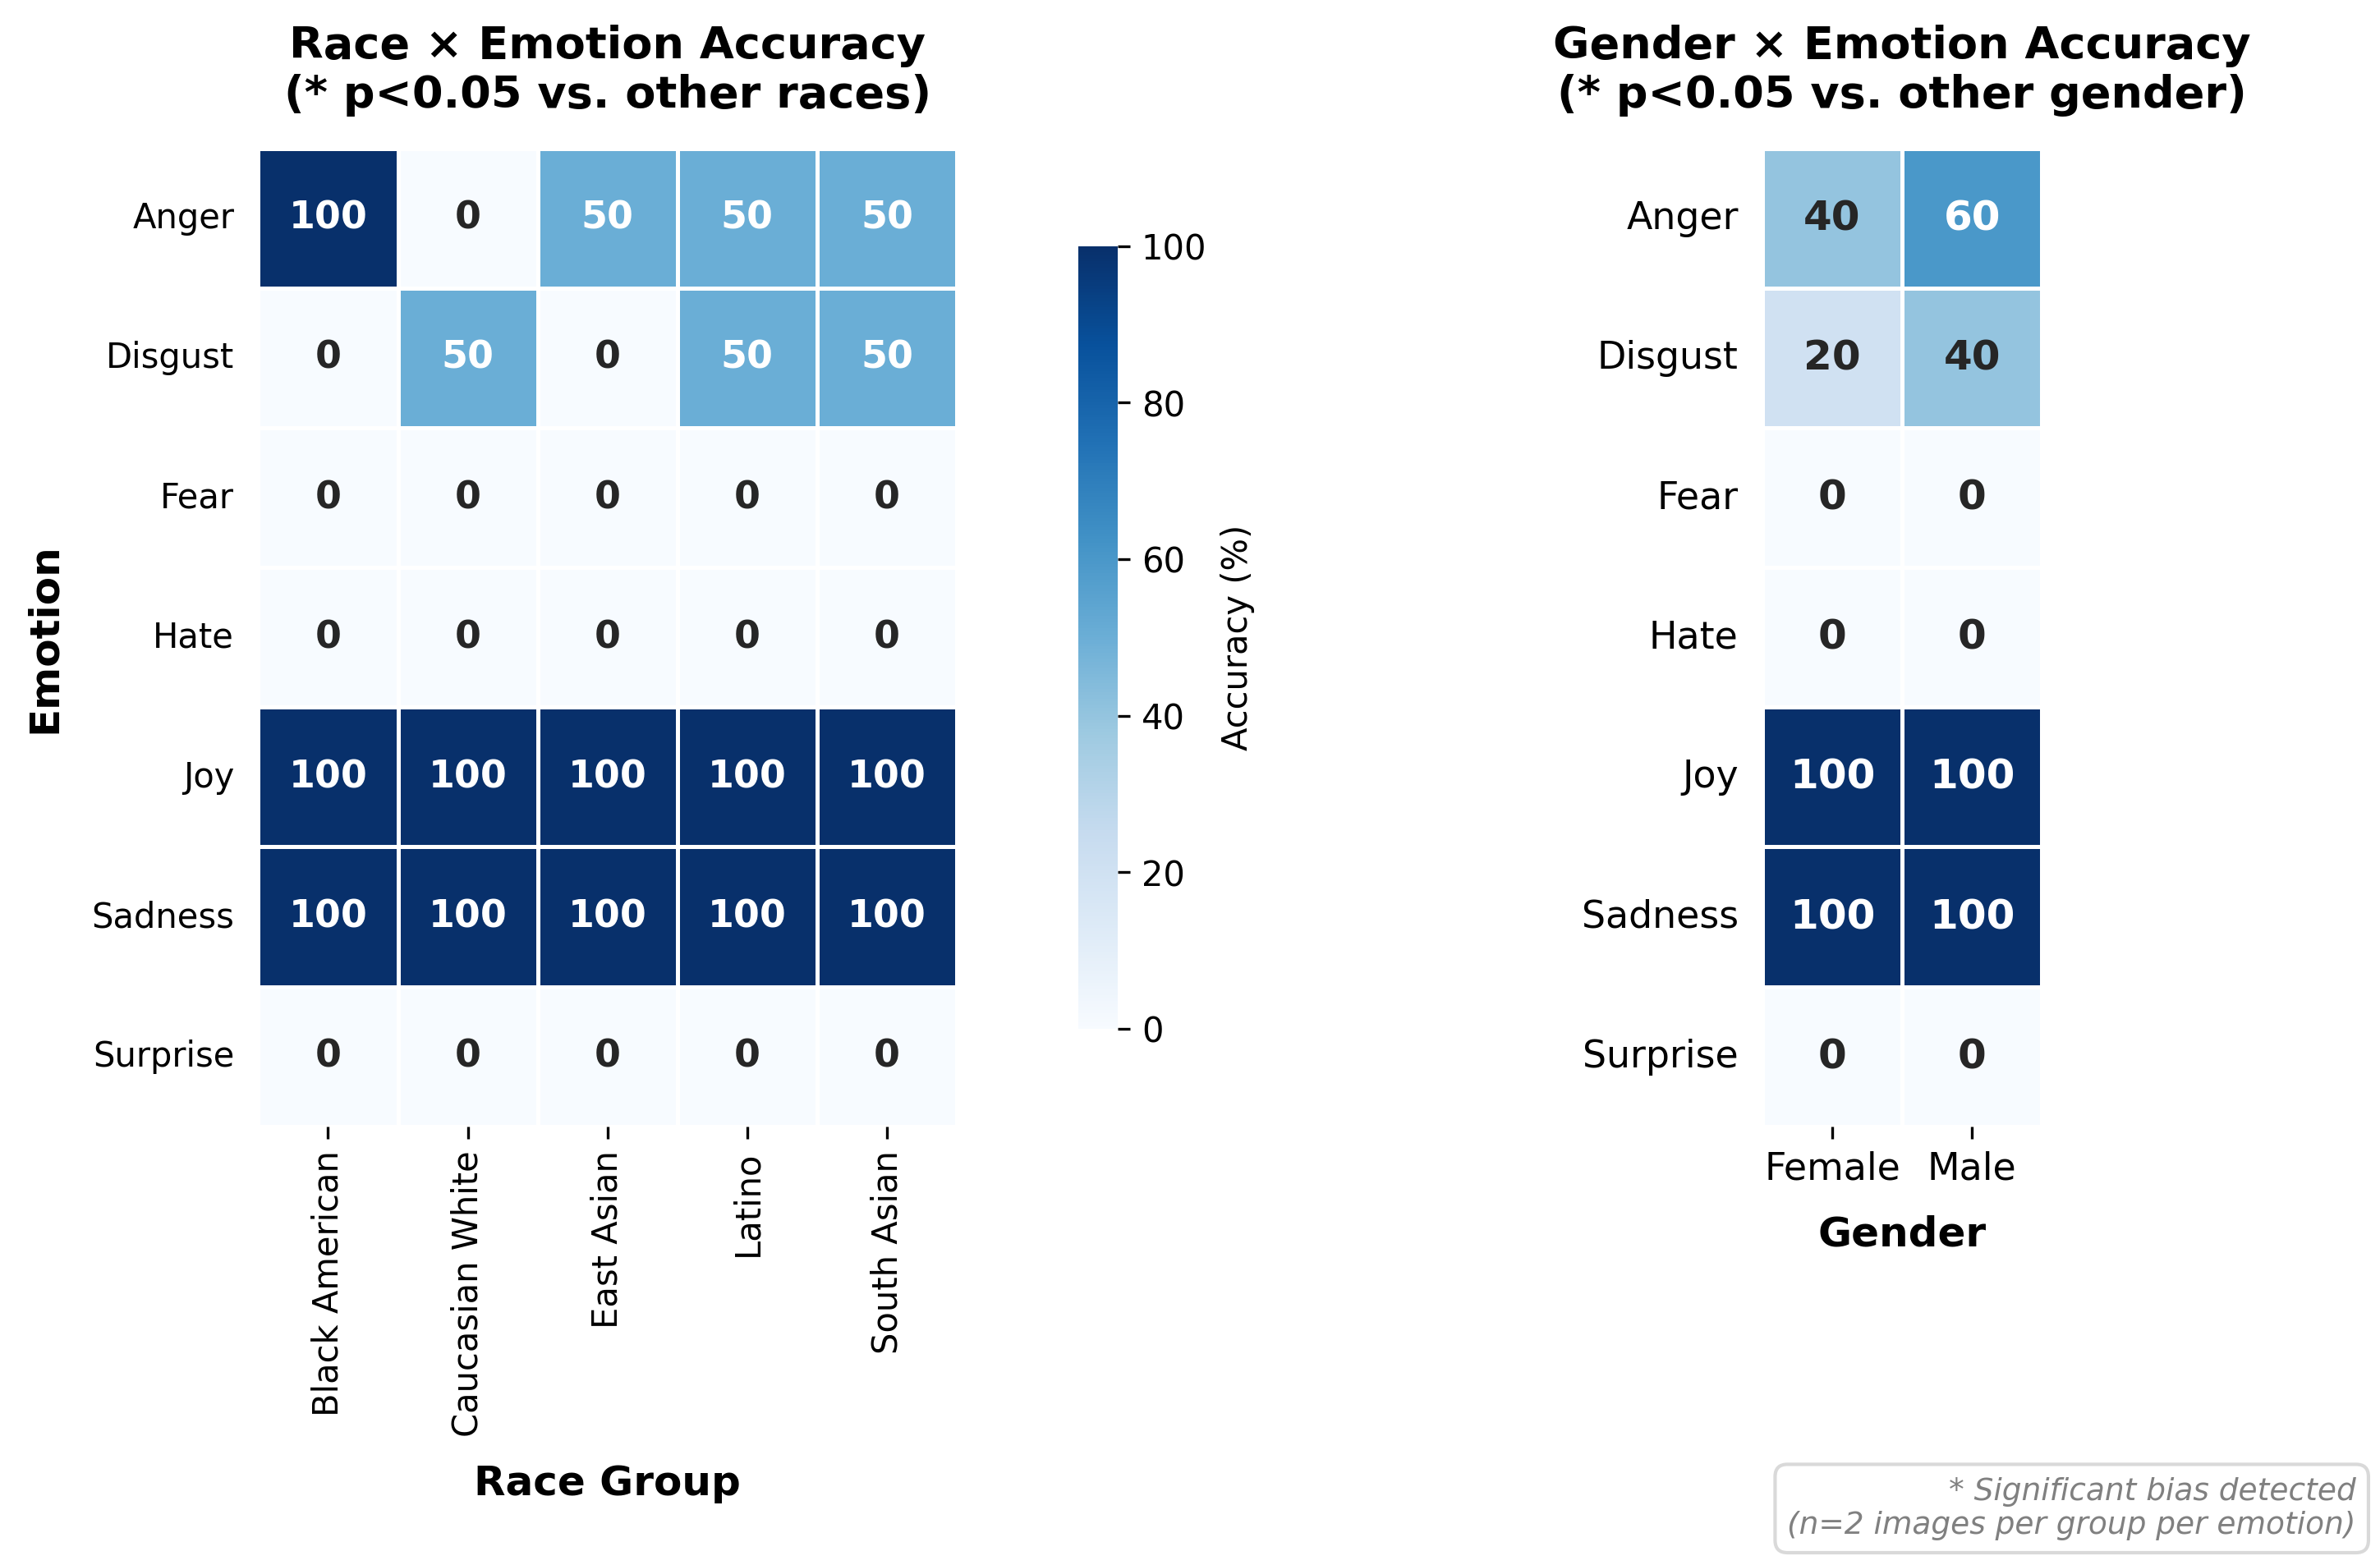

In [ ]:
# Visualization of FISHER'S EXACT TEST (Demographic Bias)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load bias test results
bias_df = pd.read_csv("/content/drive/MyDrive/Jawad Emotion AI/demographic_bias_tests.csv")

# Define consistent emotion order (psychologically meaningful sequence)
emotion_order = ['Anger', 'Disgust', 'Fear', 'Hate', 'Joy', 'Sadness', 'Surprise']

# === RACE × EMOTION HEATMAP ===
race_df = bias_df[bias_df['Demographic'] == 'Race'].copy()
race_df['Emotion'] = pd.Categorical(race_df['Emotion'], categories=emotion_order, ordered=True)
race_df = race_df.sort_values('Emotion')

# Pivot accuracy and significance
race_acc = race_df.pivot(index='Emotion', columns='Group', values='Group Accuracy (%)')
race_sig = race_df.pivot(index='Emotion', columns='Group', values='Significant (α=0.05)')

# Create annotation matrix with significance markers
race_annot = race_acc.applymap(lambda x: f"{x:.0f}" if not pd.isna(x) else "")
for i in range(race_acc.shape[0]):
    for j in range(race_acc.shape[1]):
        if not pd.isna(race_sig.iloc[i, j]) and race_sig.iloc[i, j] == 'Yes':
            race_annot.iloc[i, j] += '*'

# === GENDER × EMOTION HEATMAP ===
gender_df = bias_df[bias_df['Demographic'] == 'Gender'].copy()
gender_df['Emotion'] = pd.Categorical(gender_df['Emotion'], categories=emotion_order, ordered=True)
gender_df = gender_df.sort_values('Emotion')

gender_acc = gender_df.pivot(index='Emotion', columns='Group', values='Group Accuracy (%)')
gender_sig = gender_df.pivot(index='Emotion', columns='Group', values='Significant (α=0.05)')

gender_annot = gender_acc.applymap(lambda x: f"{x:.0f}" if not pd.isna(x) else "")
for i in range(gender_acc.shape[0]):
    for j in range(gender_acc.shape[1]):
        if not pd.isna(gender_sig.iloc[i, j]) and gender_sig.iloc[i, j] == 'Yes':
            gender_annot.iloc[i, j] += '*'

# === PLOT BOTH HEATMAPS ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6.5), dpi=300, gridspec_kw={'width_ratios': [5, 2]})

# Race heatmap
sns.heatmap(race_acc, annot=race_annot.values, fmt='', cmap='Blues',
            vmin=0, vmax=100, ax=ax1, cbar_kws={'label': 'Accuracy (%)', 'shrink': 0.8},
            linewidths=0.8, linecolor='white', square=True, annot_kws={'size': 11, 'weight': 'bold'})
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0, ha='right')

ax1.set_title('Race × Emotion Accuracy\n(* p<0.05 vs. other races)',
              fontsize=13, fontweight='bold', pad=12)
ax1.set_xlabel('Race Group', fontsize=12, fontweight='bold', labelpad=8)
ax1.set_ylabel('Emotion', fontsize=12, fontweight='bold', labelpad=8)
ax1.tick_params(labelsize=10, left=False)

# Gender heatmap
sns.heatmap(gender_acc, annot=gender_annot.values, fmt='', cmap='Blues',
            vmin=0, vmax=100, ax=ax2, cbar=False,
            linewidths=0.8, linecolor='white', square=True, annot_kws={'size': 12, 'weight': 'bold'})
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0, ha='right')

ax2.set_title('Gender × Emotion Accuracy\n(* p<0.05 vs. other gender)',
              fontsize=13, fontweight='bold', pad=12)
ax2.set_xlabel('Gender', fontsize=12, fontweight='bold', labelpad=8)
ax2.set_ylabel('', fontsize=12)
ax2.tick_params(labelsize=11, left=False)

# White background styling
fig.patch.set_facecolor('white')
ax1.set_facecolor('white')
ax2.set_facecolor('white')

# Annotation box explaining markers
fig.text(0.98, 0.03, '* Significant bias detected\n(n=2 images per group per emotion)',
         ha='right', va='bottom', fontsize=9, style='italic', color='gray',
         bbox=dict(boxstyle='round,pad=0.4', facecolor='white',
                   edgecolor='lightgray', alpha=0.85))

plt.tight_layout(rect=[0, 0.03, 1, 1])

# Save and display
save_path = "/content/drive/MyDrive/Jawad Emotion AI/demographic_bias_heatmap.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✅ Demographic bias heatmap saved: {save_path}")
plt.show()

In [ ]:
# BLOCK 5: CONTEXT SHIFT ANALYSIS
import pandas as pd

# Calculate context shift rates per model
shift_results = []
for model in ['Qwen', 'Phi', 'Idefics']:
    # Context shift column uses CAPITALIZED model name
    shift_col = f"{model}_Context_Shift"
    total_shifts = df[shift_col].sum()
    total_images = len(df)
    shift_rate = total_shifts / total_images

    # Accuracy column uses CAPITALIZED model name
    original_correct = df[f"{model}_Accuracy"] == 1

    # Black prediction column uses LOWERCASE model name
    model_lower = model.lower()
    black_correct = df[f"{model_lower}_black_predicted"] == df["Ground_Truth_Emotion"]

    harmful_shifts = ((original_correct) & (~black_correct)).sum()  # Correct → wrong
    helpful_shifts = ((~original_correct) & (black_correct)).sum()  # Wrong → correct

    shift_results.append({
        'Model': model,
        'Context Shifts': int(total_shifts),
        'Total Images': total_images,
        'Shift Rate (%)': round(shift_rate * 100, 1),
        'Harmful Shifts': int(harmful_shifts),
        'Helpful Shifts': int(helpful_shifts)
    })

shift_df = pd.DataFrame(shift_results)
print("\n🔄 CONTEXT SHIFT ANALYSIS (Original vs. Black Background)")
print("="*70)
print(shift_df.to_string(index=False))
print("="*70)
shift_df.to_csv("/content/drive/MyDrive/Jawad Emotion AI/context_shift_analysis.csv", index=False)
print("\n✅ Saved: context_shift_analysis.csv")


🔄 CONTEXT SHIFT ANALYSIS (Original vs. Black Background)
  Model  Context Shifts  Total Images  Shift Rate (%)  Harmful Shifts  Helpful Shifts
   Qwen               3            70             4.3               0               1
    Phi              19            70            27.1               5               2
Idefics              27            70            38.6               5               5

✅ Saved: context_shift_analysis.csv


✅ Context shift visualization saved: /content/drive/MyDrive/Jawad Emotion AI/context_shift_diverging.png


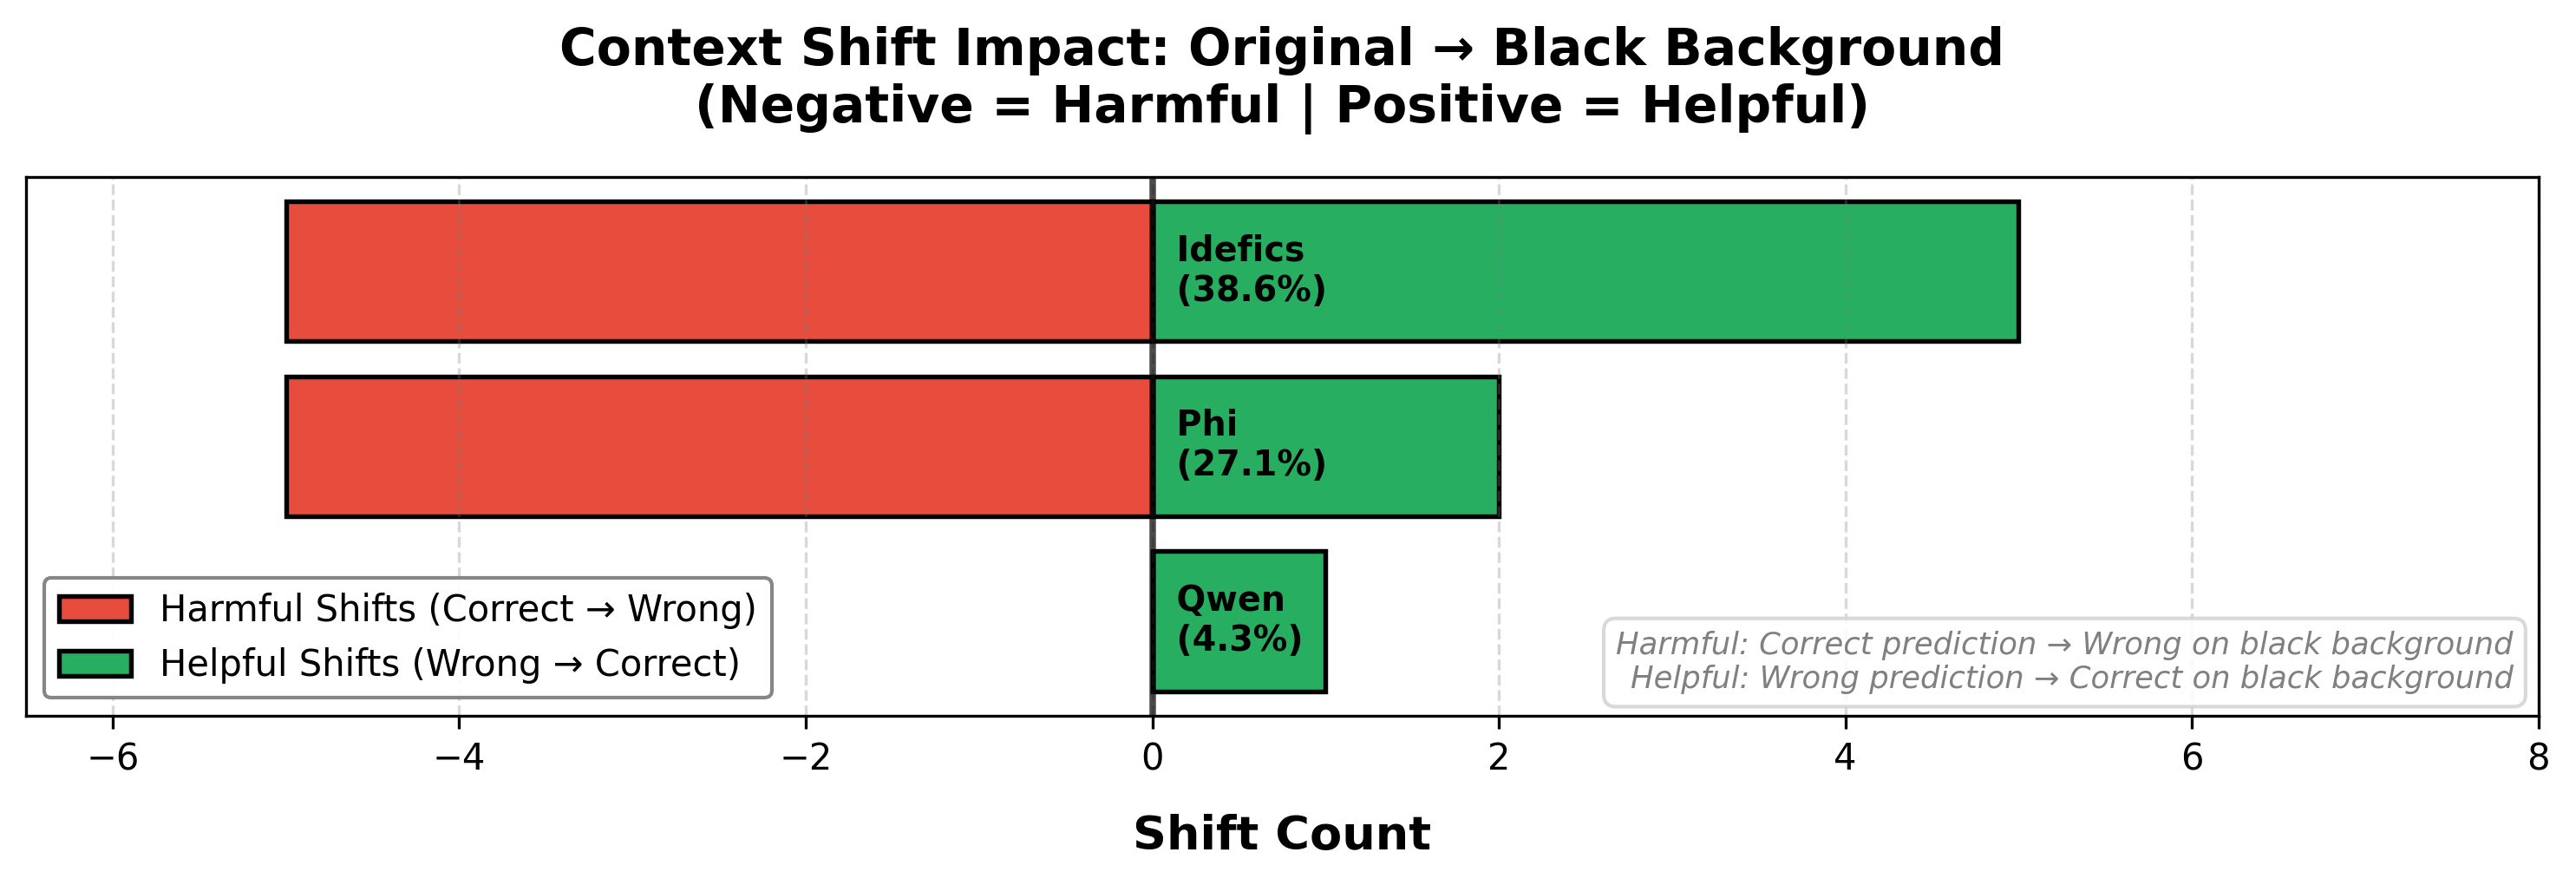

In [ ]:
# Visualization of CONTEXT SHIFT ANALYSIS
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load context shift results
shift_df = pd.read_csv("/content/drive/MyDrive/Jawad Emotion AI/context_shift_analysis.csv")

# Create diverging bar chart: harmful (left/negative) vs helpful (right/positive)
fig, ax = plt.subplots(figsize=(10, 3.5), dpi=300)

models = shift_df['Model'].values
harmful = shift_df['Harmful Shifts'].values
helpful = shift_df['Helpful Shifts'].values
shift_rate = shift_df['Shift Rate (%)'].values

# Position bars: harmful to left of center (negative), helpful to right (positive)
y_pos = np.arange(len(models))
ax.barh(y_pos, -harmful, color='#e74c3c', edgecolor='black', linewidth=1.3, label='Harmful Shifts (Correct → Wrong)')
ax.barh(y_pos, helpful, color='#27ae60', edgecolor='black', linewidth=1.3, label='Helpful Shifts (Wrong → Correct)')

# Center line (zero shift)
ax.axvline(x=0, color='black', linestyle='-', linewidth=1.8, alpha=0.7)

# Model labels with shift rate annotation
for i, (model, rate) in enumerate(zip(models, shift_rate)):
    ax.text(0, i, f'  {model}\n  ({rate}%)',
            va='center', ha='left', fontsize=9.5, fontweight='bold', color='black')

# Styling
ax.set_yticks([])
ax.set_xlabel('Shift Count', fontsize=13, fontweight='bold', labelpad=10)
ax.set_title('Context Shift Impact: Original → Black Background\n(Negative = Harmful | Positive = Helpful)',
             fontsize=14, fontweight='bold', pad=15)
ax.legend(loc='lower left', frameon=True, framealpha=0.95, edgecolor='gray', fontsize=10)
ax.grid(axis='x', linestyle='--', alpha=0.3, color='gray')
ax.set_xlim(-max(harmful)*1.3, max(helpful)*1.6)
ax.set_facecolor('white')
fig.patch.set_facecolor('white')

# Annotation box
ax.text(0.99, 0.04, 'Harmful: Correct prediction → Wrong on black background\nHelpful: Wrong prediction → Correct on black background',
        transform=ax.transAxes, ha='right', va='bottom', fontsize=8.5, style='italic', color='gray',
        bbox=dict(boxstyle='round,pad=0.4', facecolor='white', edgecolor='lightgray', alpha=0.85))

plt.tight_layout()

# Save and display
save_path = "/content/drive/MyDrive/Jawad Emotion AI/context_shift_diverging.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✅ Context shift visualization saved: {save_path}")
plt.show()

In [ ]:
# BLOCK 6: BRIER SCORE (Calibration Metric)
import numpy as np
from sklearn.metrics import brier_score_loss
import pandas as pd

# Calculate Brier score per model (measures confidence calibration)
brier_results = []
emotions = ['joy', 'sadness', 'anger', 'fear', 'disgust', 'surprise', 'hate']

for model in ['qwen', 'phi', 'idefics']:
    # Get predicted probabilities for ground truth emotion
    probs = []
    actuals = []

    for idx, row in df.iterrows():
        true_emotion = row['Ground_Truth_Emotion']
        prob_col = f"{model}_original_{true_emotion}"
        prob = row[prob_col] / 100.0  # Convert % to probability

        probs.append(prob)
        actuals.append(1)  # Always 1 since we're checking ground truth emotion

    brier = brier_score_loss(actuals, probs)
    brier_results.append({
        'Model': model.capitalize(),
        'Brier Score': round(brier, 3),
        'Interpretation': 'Well calibrated' if brier < 0.15 else 'Moderately calibrated' if brier < 0.25 else 'Poorly calibrated'
    })

brier_df = pd.DataFrame(brier_results)
print("\n🎯 BRIER SCORE (Confidence Calibration)")
print("="*60)
print(brier_df.to_string(index=False))
print("="*60)
brier_df.to_csv("/content/drive/MyDrive/Jawad Emotion AI/brier_scores.csv", index=False)
print("✅ Saved: brier_scores.csv")


🎯 BRIER SCORE (Confidence Calibration)
  Model  Brier Score    Interpretation
   Qwen        0.728 Poorly calibrated
    Phi        0.683 Poorly calibrated
Idefics        0.691 Poorly calibrated
✅ Saved: brier_scores.csv


✅ Calibration visualization saved: /content/drive/MyDrive/Jawad Emotion AI/brier_calibration.png


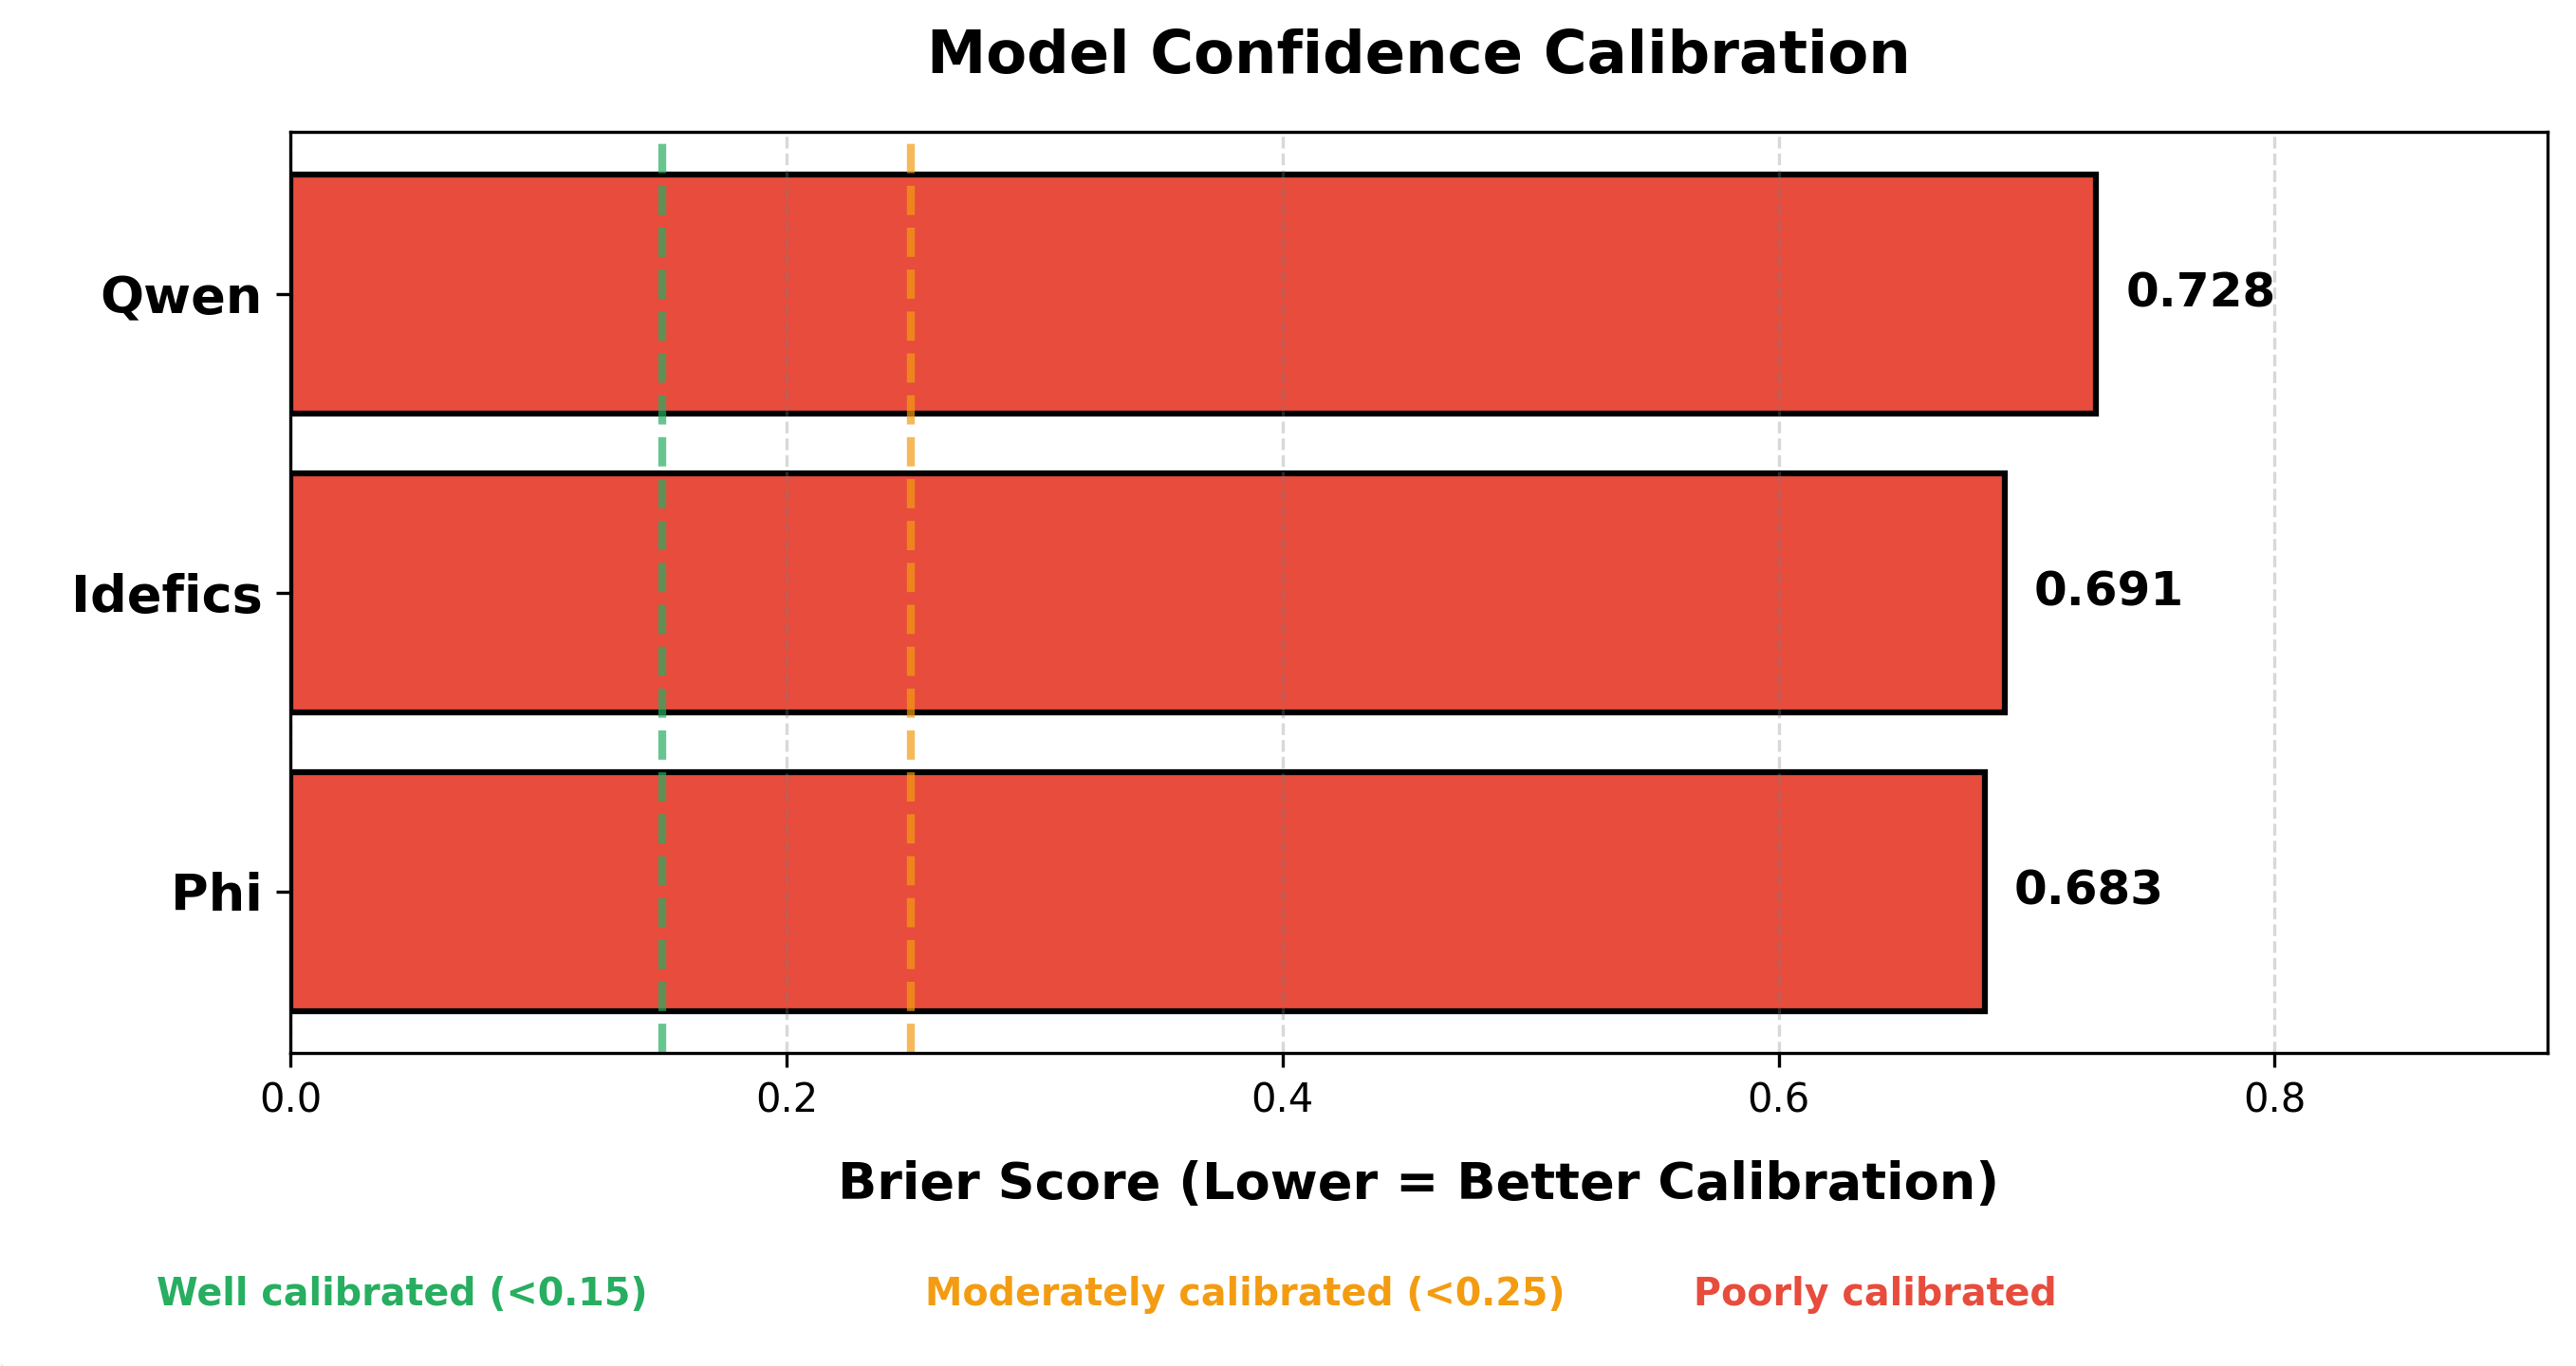

In [ ]:
# Visualization of BRIER SCORE (Calibration Metric)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyBboxPatch

# Load Brier scores
brier_df = pd.read_csv("/content/drive/MyDrive/Jawad Emotion AI/brier_scores.csv")

# Sort by calibration quality (best to worst)
brier_df = brier_df.sort_values('Brier Score', ascending=True).reset_index(drop=True)
models = brier_df['Model'].values
scores = brier_df['Brier Score'].values

# Create figure
fig, ax = plt.subplots(figsize=(9, 5), dpi=300)

# Color mapping by calibration zone
colors = []
for score in scores:
    if score < 0.15:
        colors.append('#27ae60')  # Green: well calibrated
    elif score < 0.25:
        colors.append('#f39c12')  # Yellow: moderate
    else:
        colors.append('#e74c3c')  # Red: poorly calibrated

# Horizontal bars
y_pos = np.arange(len(models))
bars = ax.barh(y_pos, scores, color=colors, edgecolor='black', linewidth=1.5)

# Add score labels on bars
for i, (score, model) in enumerate(zip(scores, models)):
    ax.text(score + 0.012, i, f'{score:.3f}',
            va='center', ha='left', fontsize=12, fontweight='bold', color='black')

# Calibration zone thresholds (vertical lines)
ax.axvline(x=0.15, color='#27ae60', linestyle='--', linewidth=2, alpha=0.7)
ax.axvline(x=0.25, color='#f39c12', linestyle='--', linewidth=2, alpha=0.7)

# Labels and styling
ax.set_yticks(y_pos)
ax.set_yticklabels(models, fontsize=13, fontweight='bold')
ax.set_xlabel('Brier Score (Lower = Better Calibration)', fontsize=13, fontweight='bold', labelpad=10)
ax.set_title('Model Confidence Calibration', fontsize=15, fontweight='bold', pad=15)
ax.set_xlim(0, max(scores) * 1.25)
ax.grid(axis='x', linestyle='--', alpha=0.3, color='gray')
ax.set_facecolor('white')
fig.patch.set_facecolor('white')

# Create bottom annotation box
box = FancyBboxPatch((0, 0), 1, 0.05,
                      boxstyle="round,pad=0.02",
                      facecolor='white',
                      edgecolor='#dddddd',
                      alpha=0.85,
                      linewidth=1.0,
                      zorder=10)
fig.patches.append(box)

# Add calibration zone labels (left-aligned)
fig.text(0.05, 0.03, 'Well calibrated (<0.15)',
         ha='left', va='center', fontsize=9.5, color='#27ae60', fontweight='bold')
fig.text(0.35, 0.03, 'Moderately calibrated (<0.25)',
         ha='left', va='center', fontsize=9.5, color='#f39c12', fontweight='bold')
fig.text(0.65, 0.03, 'Poorly calibrated',
         ha='left', va='center', fontsize=9.5, color='#e74c3c', fontweight='bold')

# Tight layout with space for bottom box
plt.tight_layout(rect=[0, 0.06, 1, 0.95])

# Save and display
save_path = "/content/drive/MyDrive/Jawad Emotion AI/brier_calibration.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✅ Calibration visualization saved: {save_path}")
plt.show()

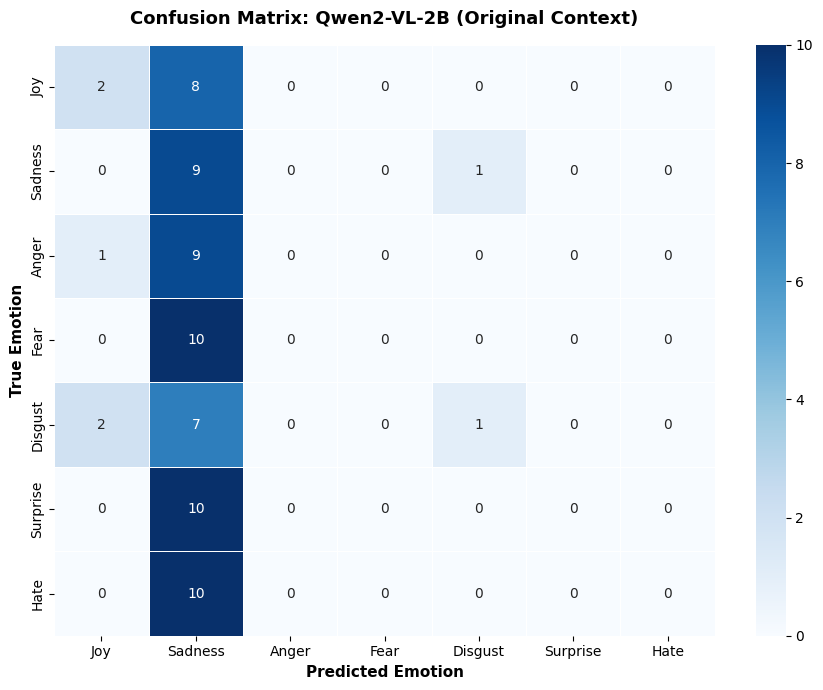

✅ Saved: confusion_matrix_qwen2.png


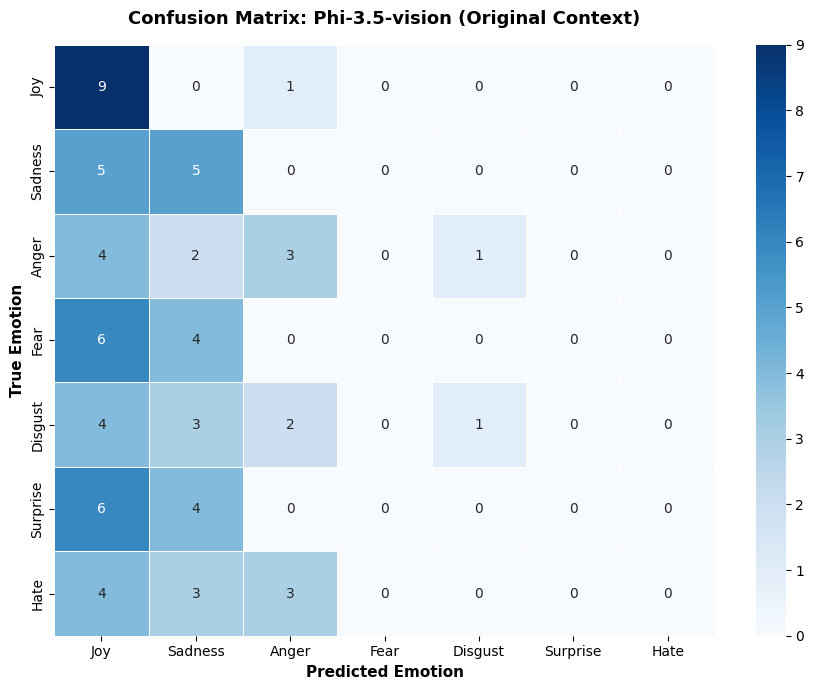

✅ Saved: confusion_matrix_phi.png


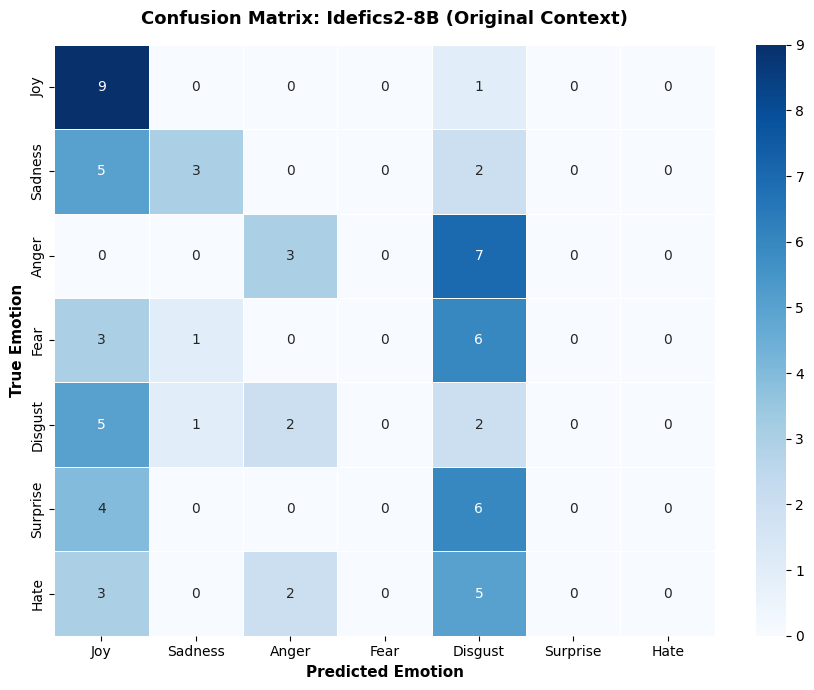

✅ Saved: confusion_matrix_idefics2.png



In [ ]:
# BLOCK 7: CONFUSION MATRICES (Per Emotion)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import os

# Create output directory if missing
output_dir = "/content/drive/MyDrive/Jawad Emotion AI"
os.makedirs(output_dir, exist_ok=True)

# Generate confusion matrices for all 3 models
models = [
    ("Qwen2-VL-2B", "qwen_original_predicted"),
    ("Phi-3.5-vision", "phi_original_predicted"),
    ("Idefics2-8B", "idefics_original_predicted")
]

for model_name, pred_col in models:
    plt.figure(figsize=(9, 7))
    cm = confusion_matrix(
        df['Ground_Truth_Emotion'],
        df[pred_col],
        labels=['joy', 'sadness', 'anger', 'fear', 'disgust', 'surprise', 'hate']
    )

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Joy', 'Sadness', 'Anger', 'Fear', 'Disgust', 'Surprise', 'Hate'],
                yticklabels=['Joy', 'Sadness', 'Anger', 'Fear', 'Disgust', 'Surprise', 'Hate'],
                linewidths=0.5, linecolor='white')

    plt.title(f'Confusion Matrix: {model_name} (Original Context)',
              fontsize=13, fontweight='bold', pad=15)
    plt.xlabel('Predicted Emotion', fontsize=11, fontweight='bold')
    plt.ylabel('True Emotion', fontsize=11, fontweight='bold')
    plt.tight_layout()

    # Save with model-specific filename
    filename = f"confusion_matrix_{model_name.split('-')[0].lower()}.png"
    filepath = f"{output_dir}/{filename}"
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    print(f"✅ Saved: {filename}")

print("\n" + "="*60)

In [ ]:
# BLOCK 8: EQUAL OPPORTUNITY DIFFERENCE (Fairness Metric)
import pandas as pd
import numpy as np

# Calculate TPR per group
fairness_data = []
for emotion in df['Ground_Truth_Emotion'].unique():
    for race in df['Race'].unique():
        subset = df[(df['Ground_Truth_Emotion'] == emotion) & (df['Race'] == race)]
        if len(subset) == 0:
            continue
        tpr = subset['MME_Score'].mean() * 100
        fairness_data.append({
            'Emotion': emotion.capitalize(),
            'Race': race,
            'TPR (%)': round(tpr, 1),
            'Group Size': len(subset)
        })

fair_df = pd.DataFrame(fairness_data)

# Calculate fairness metrics per emotion
fairness_metrics = []
for emotion in sorted(df['Ground_Truth_Emotion'].unique(), key=lambda x: ['joy','sadness','anger','fear','disgust','surprise','hate'].index(x)):
    emotion_data = fair_df[fair_df['Emotion'] == emotion.capitalize()]
    if len(emotion_data) < 2:
        continue

    tprs = emotion_data['TPR (%)'].values
    fairness_metrics.append({
        'Emotion': emotion.capitalize(),
        'Mean TPR (%)': round(np.mean(tprs), 1),
        'Std Dev TPR (%)': round(np.std(tprs, ddof=1), 1),
        'Min TPR (%)': round(np.min(tprs), 1),
        'Max TPR (%)': round(np.max(tprs), 1),
        'Max TPR Diff (%)': round(np.max(tprs) - np.min(tprs), 1),
        'Races with 0% TPR': int(np.sum(tprs == 0))
    })

metrics_df = pd.DataFrame(fairness_metrics)

print("\n⚖️ FAIRNESS METRICS BY EMOTION (Descriptive Statistics)")
print("="*70)
print(metrics_df.to_string(index=False))
print("="*70)
metrics_df.to_csv("/content/drive/MyDrive/Jawad Emotion AI/fairness_metrics.csv", index=False)
print("\n✅ Saved: fairness_metrics.csv")


⚖️ FAIRNESS METRICS BY EMOTION (Descriptive Statistics)
 Emotion  Mean TPR (%)  Std Dev TPR (%)  Min TPR (%)  Max TPR (%)  Max TPR Diff (%)  Races with 0% TPR
     Joy         100.0              0.0        100.0        100.0               0.0                  0
 Sadness         100.0              0.0        100.0        100.0               0.0                  0
   Anger          50.0             35.4          0.0        100.0             100.0                  1
    Fear           0.0              0.0          0.0          0.0               0.0                  5
 Disgust          30.0             27.4          0.0         50.0              50.0                  2
Surprise           0.0              0.0          0.0          0.0               0.0                  5
    Hate           0.0              0.0          0.0          0.0               0.0                  5

✅ Saved: fairness_metrics.csv


/tmp/ipython-input-3511382295.py:49: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(0, i,


✅ Sophisticated fairness visualization saved: /content/drive/MyDrive/Jawad Emotion AI/fairness_ladder_sophisticated.png


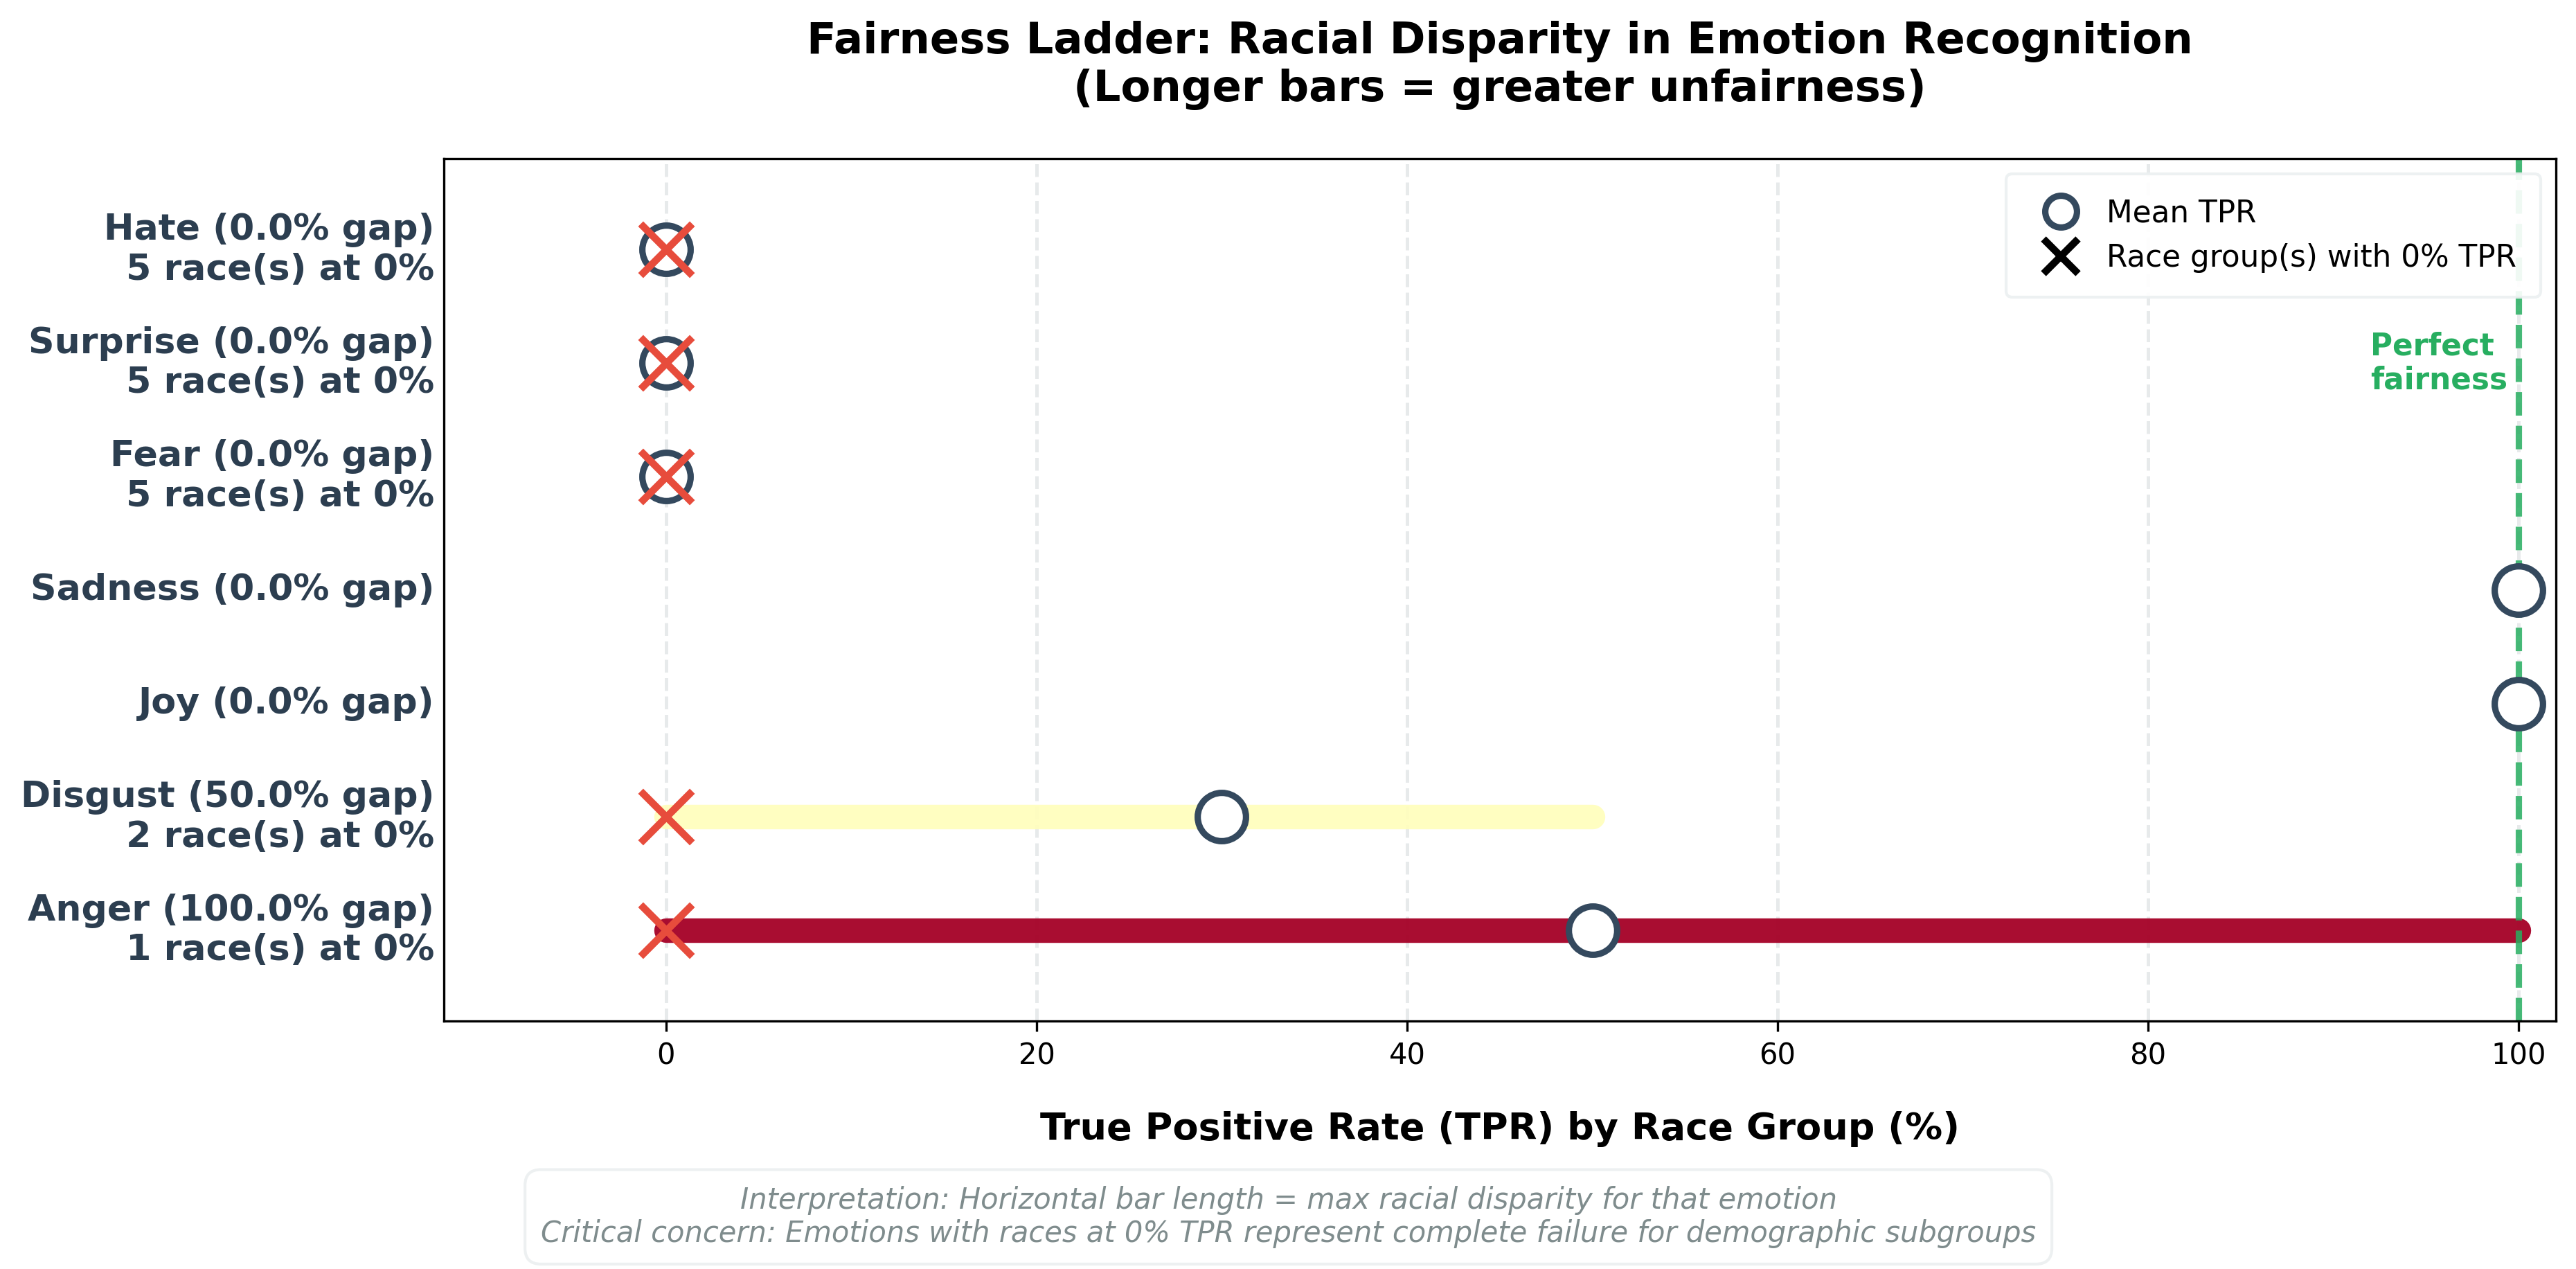

In [ ]:
# Visualization of EQUAL OPPORTUNITY DIFFERENCE (Fairness Metric)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# Load fairness metrics
metrics_df = pd.read_csv("/content/drive/MyDrive/Jawad Emotion AI/fairness_metrics.csv")

# Sort by disparity (worst to best)
metrics_df = metrics_df.sort_values('Max TPR Diff (%)', ascending=False).reset_index(drop=True)
emotions = metrics_df['Emotion'].values
min_tpr = metrics_df['Min TPR (%)'].values
max_tpr = metrics_df['Max TPR (%)'].values
mean_tpr = metrics_df['Mean TPR (%)'].values
zero_races = metrics_df['Races with 0% TPR'].values

# Create figure with
fig, ax = plt.subplots(figsize=(12.5, 6.5), dpi=300)

# Emotion positions (worst at bottom)
y_pos = np.arange(len(emotions))

# Color mapping: red (high disparity) → green (low disparity)
disparity = metrics_df['Max TPR Diff (%)'].values
norm = plt.Normalize(disparity.min(), disparity.max())
colors = plt.cm.RdYlGn_r(norm(disparity))

# Draw fairness bars
for i, (mn, mx, mean, color, zeros) in enumerate(zip(min_tpr, max_tpr, mean_tpr, colors, zero_races)):
    if mx - mn > 0.5:
        ax.plot([mn, mx], [i, i],
                color=color,
                linewidth=8.5,
                solid_capstyle='round',
                alpha=0.95,
                zorder=2)

    # Mean TPR marker
    ax.scatter(mean, i,
               s=280,
               color='white',
               edgecolor='#34495e',
               linewidth=2.2,
               zorder=3)

    # 0% TPR marker (only if exists)
    if zeros > 0:
        ax.scatter(0, i,
                   s=320,
                   marker='x',
                   color='#e74c3c',
                   edgecolor='black',
                   linewidth=2.5,
                   zorder=4)

# Add emotion labels
for i, (emotion, diff, zeros) in enumerate(zip(emotions, disparity, zero_races)):
    label = f"{emotion} ({diff:.1f}% gap)"
    if zeros > 0:
        label += f"\n {zeros} race(s) at 0%"
    ax.text(-12.5, i, label,
            ha='right',
            va='center',
            fontsize=12.5,
            fontweight='bold',
            color='#2c3e50')

# Axis styling
ax.set_yticks([])
ax.set_xlabel('True Positive Rate (TPR) by Race Group (%)',
              fontsize=13,
              fontweight='bold',
              labelpad=14)
ax.set_title('Fairness Ladder: Racial Disparity in Emotion Recognition\n(Longer bars = greater unfairness)',
             fontsize=15,
             fontweight='bold',
             pad=20)
ax.set_xlim(-12, 102)
ax.set_ylim(-0.8, len(emotions) - 0.2)
ax.grid(axis='x',
        linestyle='--',
        alpha=0.35,
        color='#bdc3c7',
        linewidth=1.2)
ax.set_facecolor('white')
fig.patch.set_facecolor('white')

# Perfect fairness reference line
ax.axvline(x=100,
           color='#27ae60',
           linestyle='--',
           linewidth=2.2,
           alpha=0.85)
ax.text(92, len(emotions)-0.5, '\n\n\n\nPerfect\nfairness',
        ha='left',
        va='top',
        fontsize=10.5,
        color='#27ae60',
        fontweight='bold')

# Create legend
legend_elements = [
    Line2D([0], [0],
            marker='o',
            color='w',
            label='Mean TPR',
            markerfacecolor='white',
            markeredgecolor='#34495e',
            markersize=11,
            markeredgewidth=2.2),
    Line2D([0], [0],
            marker='x',
            color='w',
            label='Race group(s) with 0% TPR',
            markerfacecolor='#e74c3c',
            markeredgecolor='black',
            markersize=12,
            markeredgewidth=2.5)
]
ax.legend(handles=legend_elements,
          loc='upper right',
          frameon=True,
          framealpha=0.92,
          edgecolor='#ecf0f1',
          fontsize=10.5,
          handletextpad=0.5,
          borderpad=0.8)

# Bottom annotation
fig.text(0.5, 0.018,
         'Interpretation: Horizontal bar length = max racial disparity for that emotion\n'
         'Critical concern: Emotions with races at 0% TPR represent complete failure for demographic subgroups',
         ha='center',
         va='bottom',
         fontsize=10,
         color='#7f8c8d',
         style='italic',
         bbox=dict(boxstyle='round,pad=0.55',
                   facecolor='white',
                   edgecolor='#ecf0f1',
                   alpha=0.95))

plt.tight_layout(rect=[0, 0.07, 1, 0.95])

# Save and display
save_path = "/content/drive/MyDrive/Jawad Emotion AI/fairness_ladder_sophisticated.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✅ Sophisticated fairness visualization saved: {save_path}")
plt.show()